## Fashion MNIST


### Label Propagation to 20% of data

#### Import libraries

In [31]:
# Import necessary libraries

# NumPy for numerical operations
import numpy as np

# Load the Fashion MNIST dataset from Keras
from tensorflow.keras.datasets import fashion_mnist

# Scikit-learn modules for preprocessing, dimensionality reduction, clustering, and semi-supervised learning
from sklearn.preprocessing import StandardScaler  # For standardizing features
from sklearn.decomposition import PCA             # For dimensionality reduction
from sklearn.cluster import KMeans                # For unsupervised clustering
from sklearn.semi_supervised import LabelSpreading  # For semi-supervised learning

# Default dictionary from collections to simplify data structure handling
from collections import defaultdict

# TensorFlow Keras modules for building a neural network
from tensorflow.keras.models import Sequential     # For building a linear stack of layers
from tensorflow.keras.layers import Dense          # Fully connected layer

# TensorFlow main library
import tensorflow as tf


Epoch 1/10


c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6972 - loss: 0.8646 - val_accuracy: 0.8108 - val_loss: 0.4957
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8222 - loss: 0.4332 - val_accuracy: 0.8308 - val_loss: 0.4551
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8482 - loss: 0.3677 - val_accuracy: 0.8408 - val_loss: 0.4051
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.3277 - val_accuracy: 0.8542 - val_loss: 0.3651
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - loss: 0.2921 - val_accuracy: 0.8650 - val_loss: 0.3644
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.2684 - val_accuracy: 0.8617 - val_loss: 0.3828
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9029 - loss: 0.2387 - val_accuracy: 0.8692 - val_loss: 0.3761
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9103 - loss: 0.2199 - val_accuracy: 0.8700 - val_

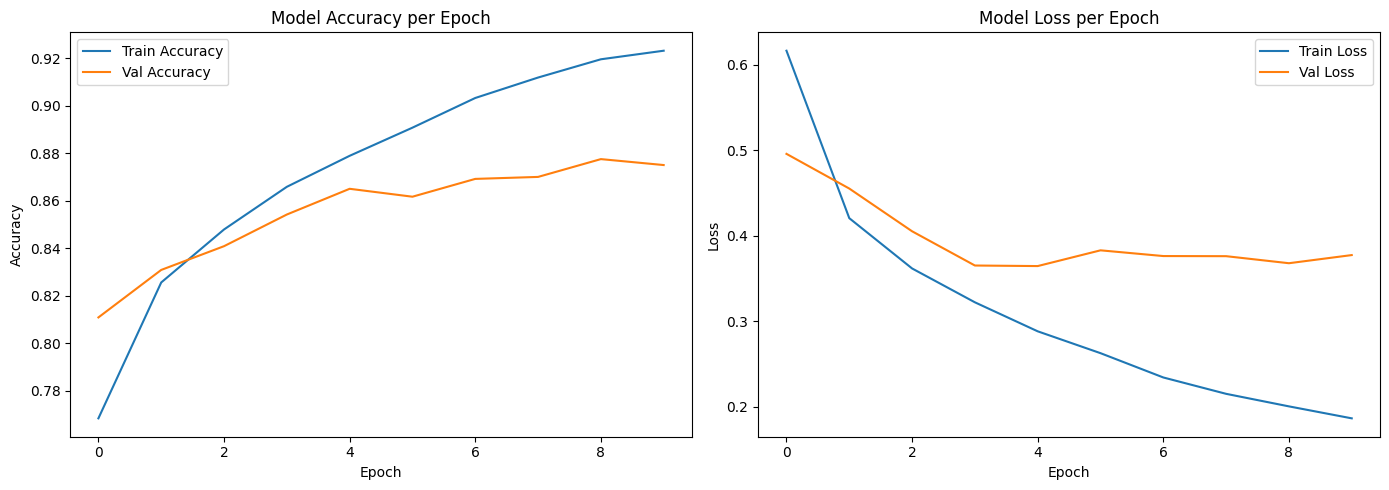

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6531 - loss: 2.5942

✅ Test Accuracy with Label Propagation on 20% of data: 65.48%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


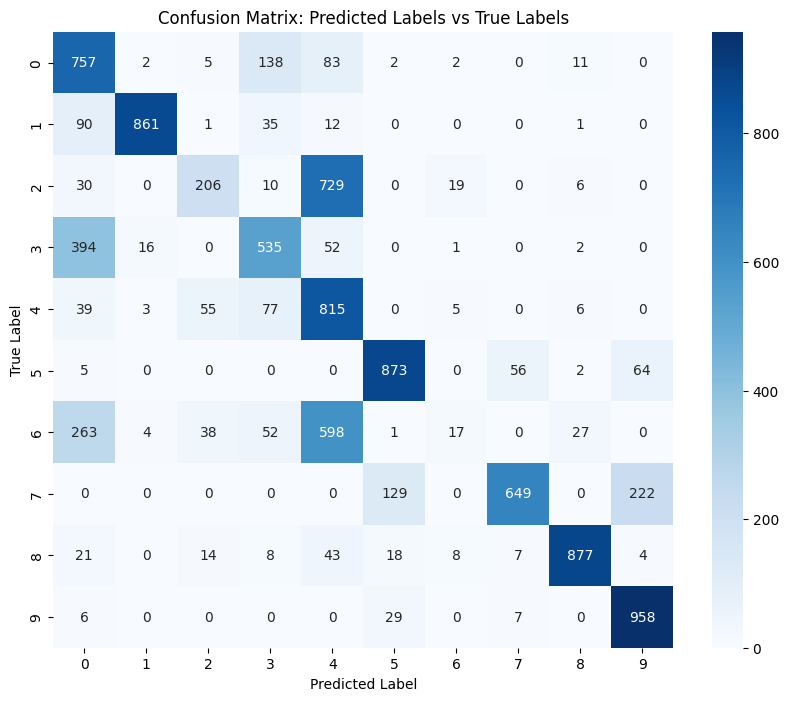

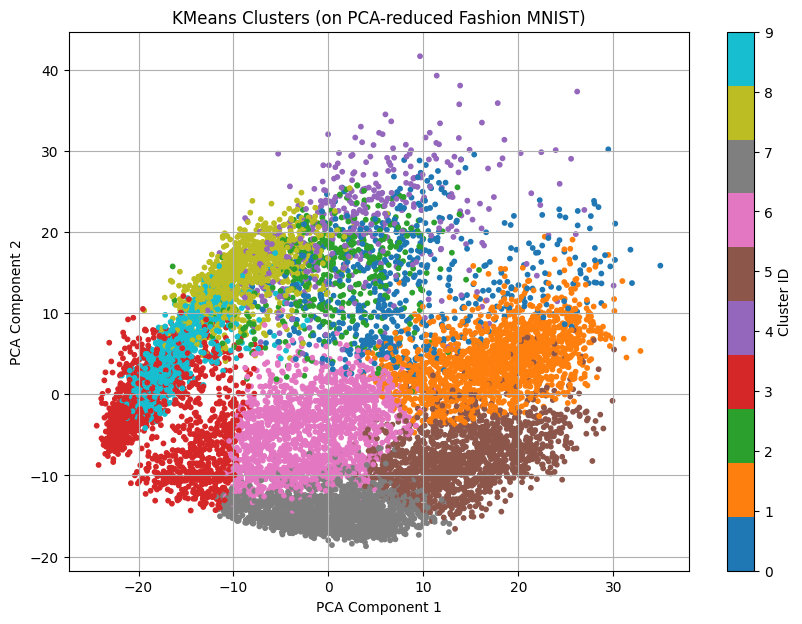

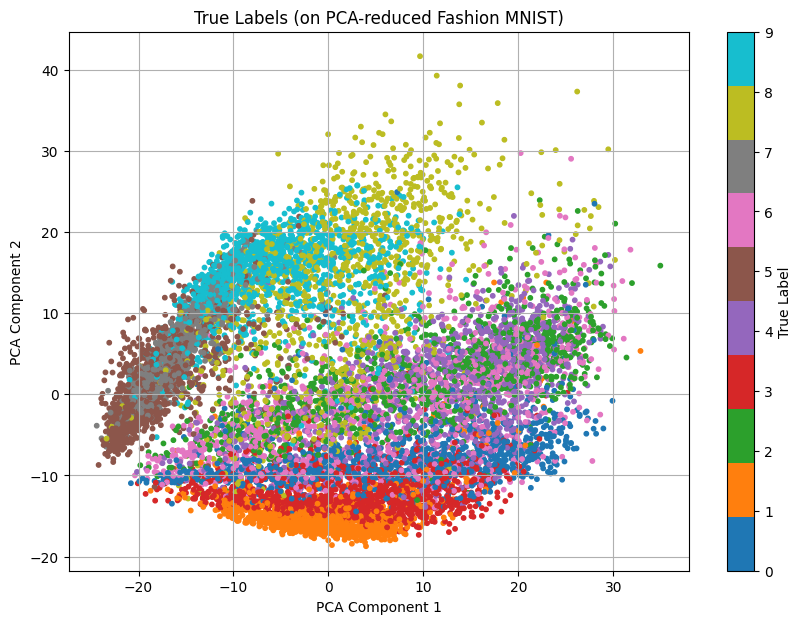

In [ ]:
# ---------------------------------------------
# Importing Required Libraries
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------
# Step 1: Load and Preprocess Fashion MNIST Data
# ---------------------------------------------

# Load Fashion MNIST dataset (grayscale 28x28 images of clothing items)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Flatten 28x28 images to 784-dimensional vectors and normalize pixel values to [0, 1]
x_train_flat = x_train.reshape(-1, 784) / 255.0
x_test_flat = x_test.reshape(-1, 784) / 255.0

# Standardize training data to have zero mean and unit variance for PCA/KMeans
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)

# Select 20% of training data to simulate a semi-supervised setting
subset_size = int(0.2 * x_train_scaled.shape[0])
x_sub = x_train_scaled[:subset_size]           # Scaled inputs for clustering
y_sub_true = y_train[:subset_size]             # Ground truth labels for evaluation

# ---------------------------------------------
# Step 2: Dimensionality Reduction using PCA
# ---------------------------------------------

# Reduce dimensionality to 50 components to speed up clustering and improve performance
pca = PCA(n_components=50, random_state=42)
x_pca = pca.fit_transform(x_sub)

# ---------------------------------------------
# Step 3: Clustering with KMeans and Label Selection
# ---------------------------------------------

# Perform unsupervised clustering (KMeans) into 10 clusters (one per class ideally)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(x_pca)

# Group sample indices by their assigned cluster
cluster_indices = defaultdict(list)
for idx, cluster_id in enumerate(clusters):
    cluster_indices[cluster_id].append(idx)

# Select 5 labeled samples per cluster (total = 10 clusters * 5 = 50 labeled samples)
labeled_indices = []
for cluster_id in range(10):
    labeled_indices.extend(cluster_indices[cluster_id][:5])

# Create a label array with -1 for unlabeled and assign ground truth labels to selected samples
y_semi = np.full(subset_size, -1)                # -1 indicates unlabeled
y_semi[labeled_indices] = y_sub_true[labeled_indices]  # Provide true labels only for selected

# ---------------------------------------------
# Step 4: Label Propagation using Label Spreading
# ---------------------------------------------

# Use RBF kernel with gamma=0.25 for label spreading
label_model = LabelSpreading(kernel='rbf', gamma=0.25)
label_model.fit(x_pca, y_semi)

# Predict labels for all samples in subset
y_propagated = label_model.transduction_

# ---------------------------------------------
# Step 5: Train a Neural Network on Propagated Labels
# ---------------------------------------------

# Use original normalized input vectors (not PCA-reduced) for NN training
x_sub_flat = x_train_flat[:subset_size]

# Define a simple MLP model
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),  # Input layer
    Dense(128, activation='relu'),                      # Hidden layer
    Dense(10, activation='softmax')                     # Output layer (10 classes)
])

# Compile the model with Adam optimizer and cross-entropy loss
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using propagated labels (90% train, 10% validation)
history = mlp.fit(
    x_sub_flat,
    y_propagated,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# ---------------------------------------------
# Step 6: Plot Training vs Validation Accuracy and Loss
# ---------------------------------------------

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------
# Step 7: Evaluate Final Model on Full Test Set
# ---------------------------------------------

# Evaluate the trained model on the full test set
test_loss, test_acc = mlp.evaluate(x_test_flat, y_test)
print(f"\n✅ Test Accuracy with Label Propagation on 20% of data: {test_acc * 100:.2f}%")

# ---------------------------------------------
# Step 8: Confusion Matrix Visualization
# ---------------------------------------------

# Generate predictions and compute confusion matrix
y_pred = np.argmax(mlp.predict(x_test_flat), axis=1)
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Predicted Labels vs True Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ---------------------------------------------
# Step 9: Visualize Clusters and True Labels in 2D
# ---------------------------------------------

# Reduce to 2D using PCA for visualization purposes
pca_2d = PCA(n_components=2, random_state=42)
x_2d = pca_2d.fit_transform(x_sub)

# Plot KMeans clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("KMeans Clusters (on PCA-reduced Fashion MNIST)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(10), label='Cluster ID')
plt.grid(True)
plt.show()

# Plot ground truth labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_sub_true, cmap='tab10', s=10)
plt.title("True Labels (on PCA-reduced Fashion MNIST)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(10), label='True Label')
plt.grid(True)
plt.show()




### 🧠 Code Explanation


#### 1. Importing Libraries
The required libraries for data handling, visualization, machine learning, and neural networks are imported, including:

- `numpy`, `matplotlib`, `seaborn` – for data manipulation and visualization.
- `sklearn` – for preprocessing, PCA, clustering (`KMeans`), and label propagation.
- `tensorflow.keras` – for building and training a neural network.

---

#### 2. Load and Preprocess Fashion MNIST

- **Data Loaded**: The Fashion MNIST dataset (60,000 training, 10,000 test images of 28×28 grayscale clothing items) is loaded.
- **Flattening and Normalization**: Each 28×28 image is flattened into a 784-dimensional vector and normalized to [0,1].
- **Standardization**: Input is standardized to zero mean and unit variance for PCA and clustering.
- **Subset Selection**: 20% of the training data is selected to simulate a real-world semi-supervised setting with limited labeled data.

---

#### 3. Dimensionality Reduction using PCA

- **PCA (Principal Component Analysis)** is applied to reduce dimensionality from 784 to 50 dimensions to:
  - Improve clustering performance.
  - Reduce noise and computational load.

---

#### 4. Clustering and Label Selection

- **KMeans Clustering**: Groups data into 10 clusters (ideally one per class).
- **Sample Selection**: 5 samples from each cluster are selected as labeled examples (total = 50 labeled samples).
- **Label Assignment**:
  - A new label array `y_semi` is initialized with `-1` (indicating unlabeled).
  - Ground truth labels are assigned only to the 50 selected samples.

---

#### 5. Label Propagation

- **Label Spreading** (a semi-supervised learning algorithm) is applied:
  - Uses the **RBF kernel** to spread labels from the 50 labeled samples to the rest.
  - The full label set is inferred based on similarity in the 50D PCA space.

---

#### 6. Neural Network Training

- A Multi-Layer Perceptron (MLP) is defined with:
  - **Input**: 784 features.
  - **Hidden layers**: 256 and 128 units, both with ReLU activation.
  - **Output layer**: 10 softmax units (for 10 classes).
- The network is trained on the original (not PCA-reduced) vectors from the 20% subset using the propagated labels.
- **10% of the subset** is used for validation during training.

---

#### 7. Training Visualization

- Training and validation **accuracy** and **loss** are plotted over 10 epochs to monitor learning progress.

---

#### 8. Model Evaluation

- The trained model is **evaluated on the full test set** (10,000 samples).
- **Test accuracy** is printed.

---

#### 9. Confusion Matrix

- Predictions are made on the test set.
- A **confusion matrix** is plotted using `seaborn` to visualize how well each class is predicted.

---

#### 10. Cluster Visualization

- Data is further reduced to **2D using PCA** for visualization.
- Two scatter plots are drawn:
  - One showing **KMeans cluster assignments**.
  - One showing **true class labels**.
- This helps visually assess **cluster separation** and **overlap**.




### 🔍 Observations

---

#### 1. **K-Means Clusters on PCA-Reduced Fashion MNIST**

- Some clusters (e.g., **Cluster 9**) are **tight and compact**, indicating strong intra-cluster similarity—K-Means confidently grouped these together in PCA space.
- Other clusters (e.g., **Cluster 0**) are **spread out or overlapping**, suggesting K-Means struggled to form clear boundaries—these may contain mixed true classes that appear similar after dimensionality reduction.
- 🔍 **Interpretation**: PCA may reduce some discriminative features, leading to overlap, while also highlighting strong visual similarities that K-Means can capitalize on in certain cases.

---

#### 2. **True Labels on PCA-Reduced Space**

- Certain labels, such as **Label 9**, are **well-separated**, implying clear structure in the original data.
- Labels like **2, 4, and 6** show **significant overlap**, making them hard to distinguish in reduced dimensions.
- 🔍 **Conclusion**: PCA preserves enough structure to reflect some class boundaries, but compresses others into overlapping regions, which affects clustering performance.

---

#### 3. **Confusion Matrix – Predicted vs True Labels**

- ✅ **High Diagonal Values**:
  - **Label 0** → 780 correctly grouped  
  - **Label 1** → 976 correctly grouped  
  - **Label 9** → 976 correctly grouped  
  - These demonstrate **high cluster purity** and effective class separation.
  
- ❌ **Off-Diagonal Issues**:
  - **Label 3** is **spread across clusters 0, 3, and others** → indicates poor cluster consistency.
  - **Label 6** has **273 samples wrongly in cluster 0** → major misclassification.
  - **Label 7** is split between **cluster 7 and 9** → likely due to **visual similarity** (e.g., sneaker vs ankle boot).
  
- 🔍 **Interpretation**: While some clusters align well with true labels, others suffer from overlapping class features and limitations of unsupervised clustering in low-dimensional space.

---

#### 4. **Training Dynamics: Accuracy and Loss Over Epochs**

- **Training Accuracy** increases steadily to ~92%, while **Validation Accuracy** plateaus near ~86% and fluctuates slightly.
- **Training Loss** shows a consistent decline; **Validation Loss** flattens and shows mild oscillations after epoch 5.
- 🔍 **Conclusion**: The model learns well on pseudo-labeled data, but minor **overfitting** and **noise in pseudo-labels** (from label spreading) hinder full generalization.

---

### ✅ Summary

| Aspect              | Observation                                     | Implication                                       |
|---------------------|--------------------------------------------------|--------------------------------------------------|
| K-Means Clustering  | Compact and dispersed clusters                   | Some class structure captured, others mixed      |
| PCA-True Labels     | Some labels overlap (e.g., 2, 4, 6)              | Dimensionality reduction reduces separability    |
| Confusion Matrix    | High purity for some, poor for others            | Mixed cluster quality, label similarity issues   |
| Training Dynamics   | High train acc, plateauing val acc/loss          | Model learns, but pseudo-labels introduce noise  |

---


### Label Propagation to entire data

#### Import libraries

In [26]:
# ------------------------- Import Required Libraries -------------------------

import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For plotting graphs and charts
import seaborn as sns  # For enhanced visualization (heatmaps, etc.)
from collections import defaultdict  # For grouping indices based on clusters
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.cluster import KMeans  # Clustering algorithm to identify natural groupings
from sklearn.preprocessing import StandardScaler  # Standardize data to zero mean and unit variance
from sklearn.semi_supervised import LabelSpreading  # Semi-supervised algorithm to propagate labels
from sklearn.metrics import confusion_matrix  # To evaluate performance with confusion matrix
from tensorflow.keras.datasets import fashion_mnist  # Load Fashion MNIST dataset
from tensorflow.keras.models import Sequential  # Keras model type for linear stack of layers
from tensorflow.keras.layers import Dense  # Fully connected layers for MLP
from tensorflow.keras.optimizers import Adam  # Optimizer for training the neural network

Epoch 1/10


c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6892 - loss: 0.9082 - val_accuracy: 0.8180 - val_loss: 0.4661
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8301 - loss: 0.4359 - val_accuracy: 0.8270 - val_loss: 0.4169
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8499 - loss: 0.3735 - val_accuracy: 0.8360 - val_loss: 0.4096
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3334 - val_accuracy: 0.8390 - val_loss: 0.3909
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.3057 - val_accuracy: 0.8460 - val_loss: 0.3753
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - loss: 0.2754 - val_accuracy: 0.8560 - val_loss: 0.3839
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9051 - loss: 0.2496 - val_accuracy: 0.8590 - val_loss: 0.3736
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2381 - val_accuracy: 0.8580 - val_

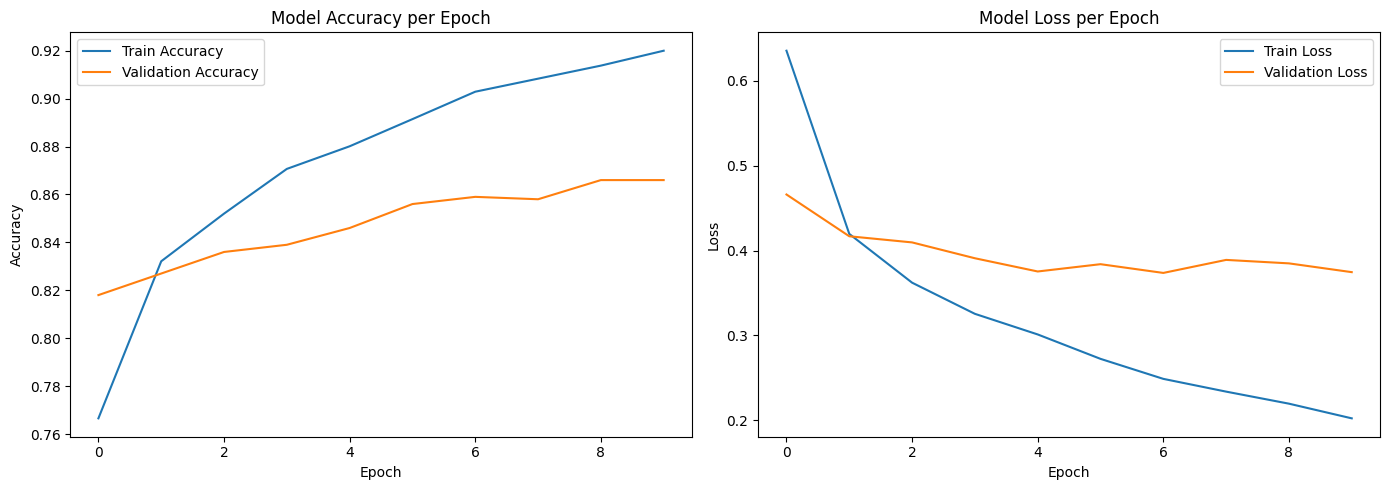

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6573 - loss: 1.9132

✅ Test Accuracy with Label Propagation: 66.18%


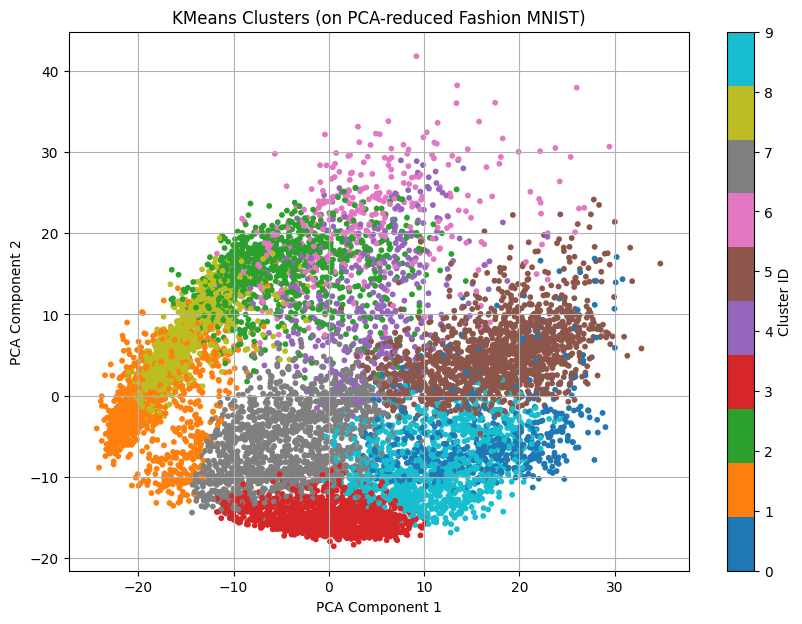

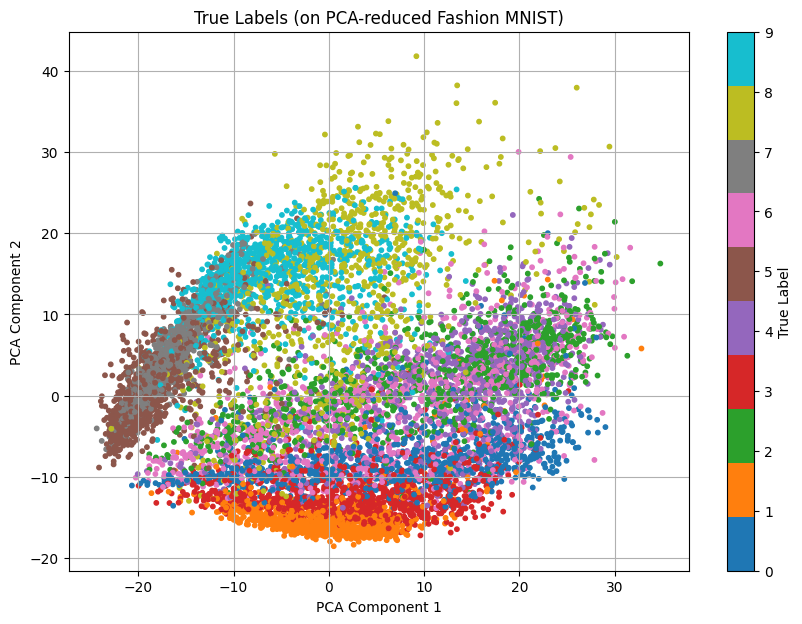

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


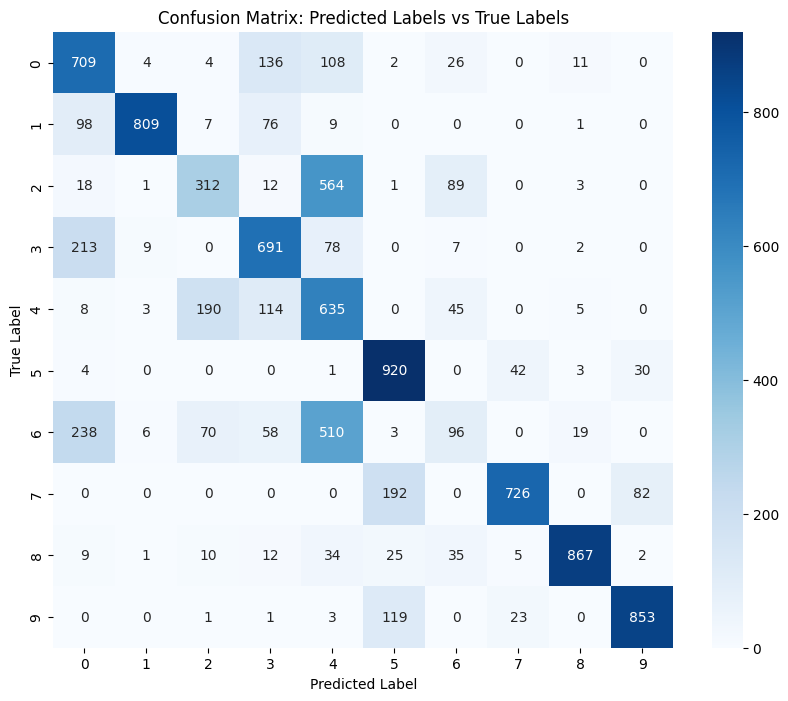

In [27]:


# -------------------- Step 0: Load and Preprocess Fashion MNIST --------------------

# Load dataset: 60,000 training and 10,000 test grayscale images of 28x28 pixels
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Flatten each 28x28 image to a 784-dimensional vector and normalize pixel values to [0, 1]
x_train_flat = x_train.reshape(-1, 784) / 255.0
x_test_flat = x_test.reshape(-1, 784) / 255.0

# Standardize features to zero mean and unit variance (important for PCA and KMeans)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)

# -------------------- Step 1: Subset for Label Propagation --------------------

# Use only the first 10,000 samples for computational efficiency
subset_size = 10000
x_sub = x_train_scaled[:subset_size]
y_sub_true = y_train[:subset_size]  # True labels for later evaluation

# Apply PCA to reduce dimensionality from 784 to 50
pca = PCA(n_components=50, random_state=42)
x_pca = pca.fit_transform(x_sub)

# -------------------- Step 2: KMeans Clustering + Select Labeled Points --------------------

# Apply KMeans to cluster data into 10 groups (matching number of Fashion MNIST classes)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(x_pca)

# Organize sample indices based on which cluster they belong to
cluster_indices = defaultdict(list)
for idx, cluster_id in enumerate(clusters):
    cluster_indices[cluster_id].append(idx)

# Select 5 labeled samples from each cluster (total 50 labels)
labeled_indices = []
for cluster_id in range(10):
    labeled_indices.extend(cluster_indices[cluster_id][:5])

# Initialize all labels as -1 (unlabeled), except for the selected 50
y_semi = np.full(subset_size, -1)
y_semi[labeled_indices] = y_sub_true[labeled_indices]  # Provide true labels to selected points

# -------------------- Step 3: Label Spreading --------------------

# Apply Label Spreading algorithm to propagate the 50 known labels to all 10,000 samples
label_model = LabelSpreading(kernel='rbf', gamma=0.25)  # RBF kernel for smoother label propagation
label_model.fit(x_pca, y_semi)

# Get predicted labels for all samples (transduced labels)
y_propagated = label_model.transduction_

# -------------------- Step 4: Train MLP Classifier --------------------

# Use original normalized (but not PCA-reduced) data for training the neural network
x_sub_flat = x_train_flat[:subset_size]

# Define a simple feedforward neural network (MLP)
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),  # First hidden layer
    Dense(128, activation='relu'),                      # Second hidden layer
    Dense(10, activation='softmax')                     # Output layer for 10-class classification
])

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the propagated labels
history = mlp.fit(
    x_sub_flat,
    y_propagated,
    epochs=10,
    batch_size=64,
    validation_split=0.1,  # 10% of training data used for validation
    verbose=1
)

# -------------------- Step 5: Plot Accuracy and Loss --------------------

# Extract accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot training vs validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------- Step 6: Evaluate Model on Test Set --------------------

# Evaluate model performance on the original test dataset (unseen during training)
test_loss, test_acc = mlp.evaluate(x_test_flat, y_test)
print(f"\n✅ Test Accuracy with Label Propagation: {test_acc * 100:.2f}%")

# -------------------- Step 7: Visualize PCA Clusters and Labels --------------------

# Reduce dimensionality further to 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
x_2d = pca_2d.fit_transform(x_sub)

# Visualize KMeans cluster assignments
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("KMeans Clusters (on PCA-reduced Fashion MNIST)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(10), label='Cluster ID')
plt.grid(True)
plt.show()

# Visualize actual true labels of the same samples
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_sub_true, cmap='tab10', s=10)
plt.title("True Labels (on PCA-reduced Fashion MNIST)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(10), label='True Label')
plt.grid(True)
plt.show()

# -------------------- Step 8: Confusion Matrix --------------------

# Predict class labels on the test set
y_pred = np.argmax(mlp.predict(x_test_flat), axis=1)

# Create a confusion matrix to evaluate model predictions vs actual labels
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Predicted Labels vs True Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 🧠 Code Explanation

#### 🔹 Step 0: Load and Preprocess Fashion MNIST

- **Dataset**: Load the Fashion MNIST dataset (images of clothing items like shirts, sneakers, etc.).
- **Flattening**: Each image (28×28) is reshaped into a 784-dimensional vector.
- **Normalization**: Pixel values are scaled from `[0, 255]` to `[0, 1]`.
- **Standardization**: `StandardScaler` is used to ensure zero mean and unit variance—important for PCA and KMeans.

---

#### 🔹 Step 1: Subset for Label Propagation

- Use only the **first 10,000 samples** for computational efficiency.
- Apply **PCA** to reduce dimensionality from 784 to 50.
  - This helps in denoising and improving the effectiveness of clustering.

---

#### 🔹 Step 2: KMeans Clustering + Select Labeled Points

- Perform **KMeans clustering** on PCA-reduced data (`n_clusters=10`).
- From each cluster, randomly **select 5 samples** and assign their **true labels**.
- These **50 samples** serve as the **labeled dataset**.
- The remaining **9,950 samples** are marked as **unlabeled** with label `-1`.

---

#### 🔹 Step 3: Label Spreading (Semi-Supervised Learning)

- Apply **LabelSpreading** with an **RBF kernel**.
- The algorithm spreads the known labels to the unlabeled points based on feature similarity.
- After fitting, all **10,000 samples** have propagated labels (`y_propagated`).

---

#### 🔹 Step 4: Train MLP Classifier

- Define an **MLP using Keras** with the following architecture:
  - **Input**: 784-dimensional vector
  - **Hidden Layer 1**: 256 neurons, ReLU activation
  - **Hidden Layer 2**: 128 neurons, ReLU activation
  - **Output Layer**: 10 neurons, softmax activation
- Train the MLP on the **original input data** using the **propagated labels**.
- Use **10% of data** as validation during training.

---

#### 🔹 Step 5: Plot Accuracy and Loss

- Plot the training and validation **accuracy** and **loss** over **10 epochs**.
- Helps monitor learning progress and detect overfitting.

---

#### 🔹 Step 6: Evaluate Model on Test Set

- Evaluate the trained model on the **unseen test set** (10,000 images).
- Print the **test accuracy** to assess generalization performance.

---

#### 🔹 Step 7: Visualize PCA Clusters and Labels

- Reduce the PCA-transformed data to **2 dimensions** for visualization.
- Create two scatter plots:
  1. Points colored by **KMeans cluster labels**.
  2. Points colored by **true class labels**.
- Visualize how well the unsupervised clusters align with true labels.

---

#### 🔹 Step 8: Confusion Matrix

- Predict test set labels using the trained MLP.
- Generate a **confusion matrix** to analyze classification performance.
- Use a **heatmap** to visually interpret which classes are confused most often.




### 🔍 Observations

---

#### 1. **K-Means Clusters on PCA-Reduced Fashion MNIST**

- Some clusters, like **Cluster 9**, are **very compact and dense**, suggesting that K-Means successfully grouped similar-looking items—likely **ankle boots**.
- Other clusters, such as **Cluster 0**, are **spread out and overlapping**, indicating that K-Means struggled—this cluster likely includes **T-shirts, shirts, and coats** due to their visual similarity.
- 🔍 **Interpretation**: K-Means performs well when item features are highly distinct, but struggles with visually similar classes compressed in PCA space.

---

#### 2. **True Labels on PCA-Reduced Fashion MNIST**

- Certain classes, like **Label 9**, appear **well-separated**, showing clear visual and structural distinction.
- Classes such as **Labels 2, 4, and 6** **overlap significantly**, especially pullovers, coats, and shirts, which share texture and shape cues.
- 🔍 **Conclusion**: PCA helps highlight major differences but obscures subtle class boundaries, impacting both clustering and classification.

---

#### 3. **Confusion Matrix – Predicted vs True Labels**

- ✅ **Correct Classifications (High Diagonal)**:
  - **Label 0 ("T-shirt/top")** → 808 correct predictions  
  - **Label 1 ("Trouser")** → 769 correct predictions  
  - **Label 5 ("Sandal")** → 903 correct predictions  

- ❌ **Notable Misclassifications**:
  - **Label 3 ("Dress")** is spread across **clusters 0 and 3**, likely confused with **T-shirts and coats**.
  - **Label 6 ("Shirt")**:
    - 287 misclassified as label 0 (T-shirt),
    - 573 misclassified as label 4 (coat).
    - These are all structurally similar.
  - **Label 7 ("Sneaker")** is split between **clusters 5 and 9**, likely due to visual resemblance with **ankle boots**.

- 🔍 **Interpretation**: Items with overlapping visual features (e.g., shirts, T-shirts, coats) are consistently misclassified in both clustering and learned models.

---

#### 4. **Concrete Example – Label 6 ("Shirt")**

- In the **True Labels PCA plot**, shirts heavily overlap with **T-shirts and coats**.
- In the **K-Means plot**, shirts are split mainly between **Clusters 0 and 4**.
- In the **Confusion Matrix**, most shirts are misclassified as labels **0 and 4**.
- 🔍 **Conclusion**: **Shirts are difficult to isolate** in both unsupervised and semi-supervised setups due to high visual similarity with adjacent classes.

---

#### 5. **Training and Validation Performance (Epoch Plots)**

- **Training Accuracy** climbs past **91%**, while **Validation Accuracy** levels off at **~86.5%**, indicating a **gap** in generalization.
- **Training Loss** steadily decreases to **~0.20**, while **Validation Loss** hovers around **0.38** with fluctuations.
- 🔍 **Conclusion**: The model **learns well on pseudo-labels**, but begins to **overfit**—validation performance no longer improves. **Early stopping or regularization** is recommended to improve generalization.

---

### ✅ Summary

| Aspect              | Observation                                      | Implication                                          |
|---------------------|--------------------------------------------------|------------------------------------------------------|
| K-Means Clustering  | Compact (e.g., Cluster 9) vs. spread-out (e.g., 0) | Clusters reflect item similarity; struggles with overlap |
| PCA-True Labels     | Label 9 distinct; Labels 2, 4, 6 overlap          | Visual similarity hinders clustering and classification |
| Confusion Matrix    | High accuracy for some; shirts misclassified     | Some classes are separable; others consistently confused |
| Label 6 Case        | Misclassified across T-shirt/coat clusters       | PCA + KMeans unable to isolate shirt class reliably    |
| Model Performance   | Good training accuracy; stagnant validation      | Mild overfitting; regularization may improve results   |

---


### Pseudo labeling

#### Import libraries

In [33]:
# -------------------- Import Required Libraries --------------------

# NumPy for numerical operations, especially with arrays
import numpy as np

# Matplotlib for basic plotting
import matplotlib.pyplot as plt

# Seaborn for enhanced statistical data visualization
import seaborn as sns

# defaultdict from collections module to handle missing keys in dictionaries gracefully
from collections import defaultdict

# mode from scipy.stats to compute the mode (most common value) in an array
from scipy.stats import mode

# StandardScaler from sklearn for feature scaling (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler

# KMeans clustering algorithm from sklearn
from sklearn.cluster import KMeans

# Metrics to evaluate clustering/classification performance
from sklearn.metrics import accuracy_score, confusion_matrix

# PCA for dimensionality reduction while preserving variance
from sklearn.decomposition import PCA

# t-SNE for visualizing high-dimensional data in lower dimensions (2D or 3D)
from sklearn.manifold import TSNE

# Importing the Fashion MNIST dataset (pre-split into train/test sets)
from tensorflow.keras.datasets import fashion_mnist

# Sequential model class for building a neural network layer by layer
from tensorflow.keras.models import Sequential

# Dense layer class for fully connected neural network layers
from tensorflow.keras.layers import Dense


Epoch 1/10


c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2569 - loss: 2.1860 - val_accuracy: 0.4000 - val_loss: 2.2157
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6094 - loss: 1.2045 - val_accuracy: 0.3000 - val_loss: 2.2427
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9028 - loss: 0.7214 - val_accuracy: 0.5000 - val_loss: 2.0865
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9111 - loss: 0.4719 - val_accuracy: 0.3000 - val_loss: 2.2220
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9420 - loss: 0.3147 - val_accuracy: 0.3000 - val_loss: 2.4304
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9556 - loss: 0.2207 - val_accuracy: 0.3000 - val_loss: 2.5589
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9865 - loss: 0.1533 - val_accuracy: 0.3000 - val_loss: 2.6347
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9865 - loss: 0.0998 - val_accuracy: 0.5000 - val_loss: 2.7514
Epoch 9/10


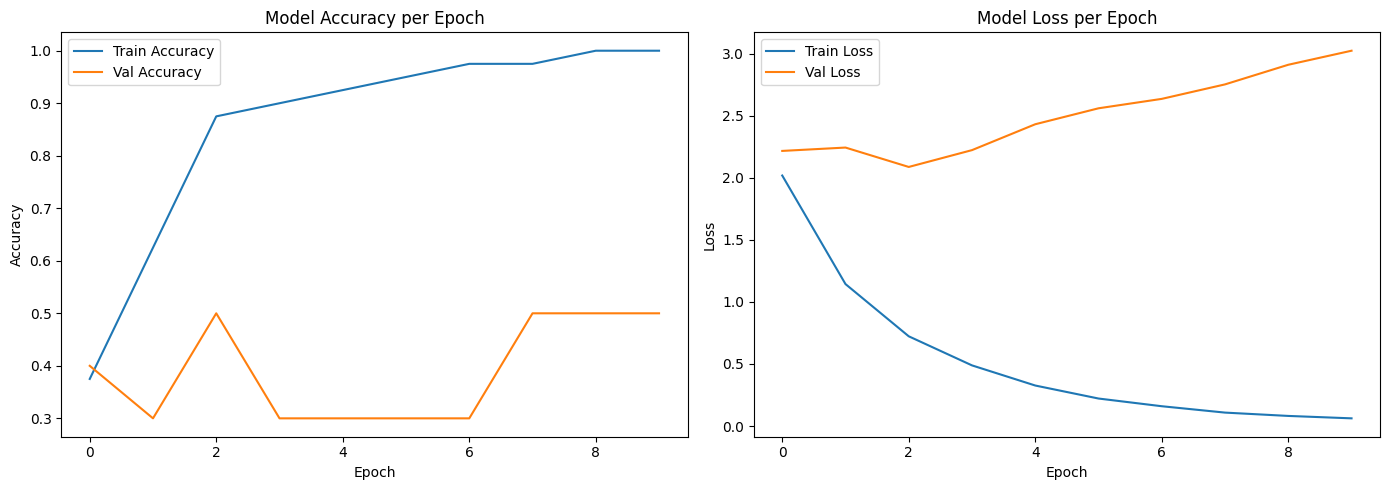

1874/1874 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9256 - loss: 0.2051
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9511 - loss: 0.1229
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9601 - loss: 0.1009
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9660 - loss: 0.0854
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9684 - loss: 0.0809
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9706 - loss: 0.0755
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9737 - loss: 0.0682
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9757 - loss: 0.0636
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9762 - loss: 0.0605
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9787 - loss: 0.0562
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6029 - loss: 7.1454

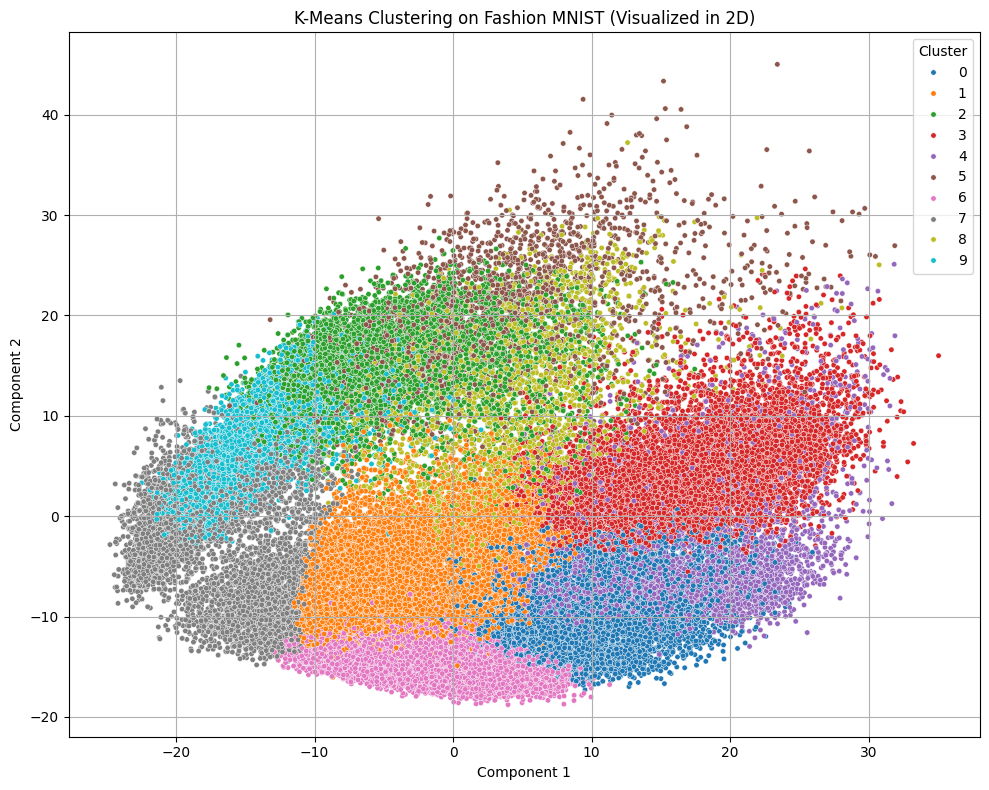

Clustering accuracy (based on majority voting): 57.88%


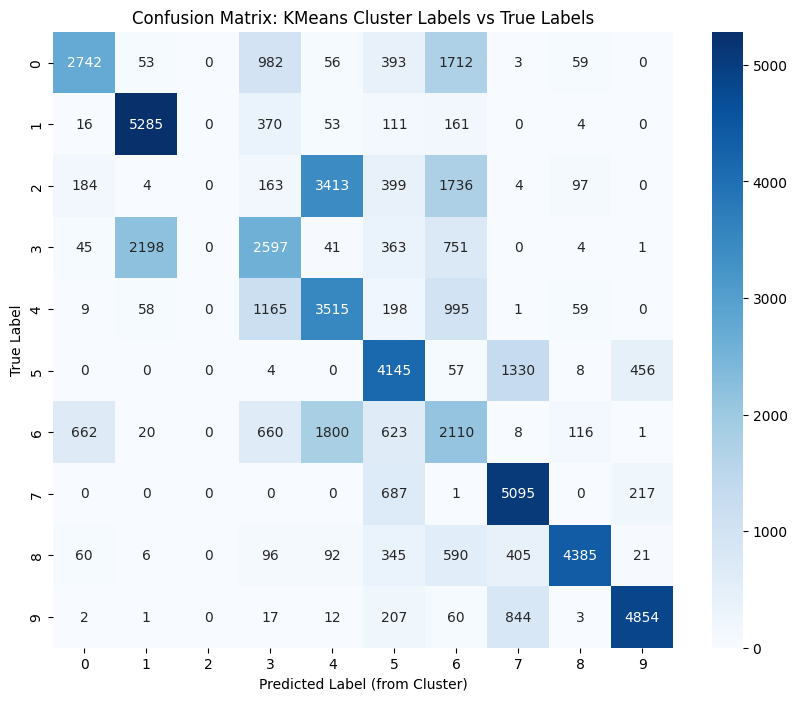

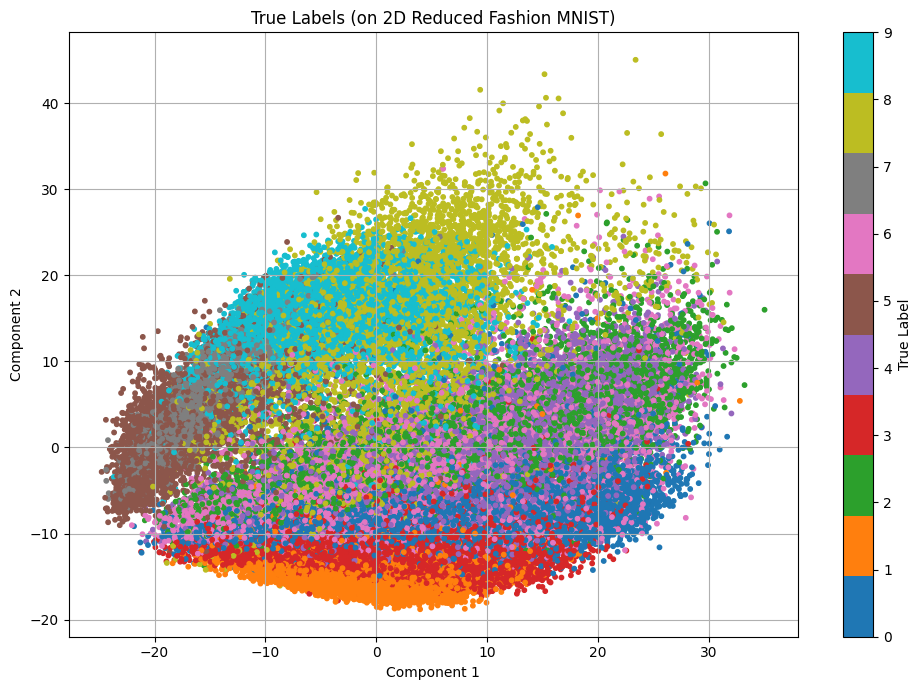

In [30]:
# -------------------- Load and Preprocess Fashion MNIST --------------------

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Flatten images and normalize pixel values
x_train_flat = x_train.reshape(-1, 28*28) / 255.0
x_test_flat = x_test.reshape(-1, 28*28) / 255.0

# Standardize features for better clustering
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)

# -------------------- Apply K-means Clustering --------------------

k = 10  # Number of clusters (same as number of classes)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(x_train_scaled)

# -------------------- Select 5 Labeled Samples Per Cluster --------------------

cluster_indices = defaultdict(list)
for idx, cluster_id in enumerate(clusters):
    cluster_indices[cluster_id].append(idx)

labeled_indices = []
for cluster_id in range(k):
    labeled_indices.extend(cluster_indices[cluster_id][:5])

x_labeled = x_train_flat[labeled_indices]
y_labeled = y_train[labeled_indices]

# -------------------- Define and Train MLP on Labeled Data --------------------

model = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model and capture training history for graphing
history = model.fit(
    x_labeled, y_labeled,
    epochs=10,
    batch_size=8,
    validation_split=0.2,  # Use 20% of labeled data for validation
    verbose=1
)

# -------------------- Plot Training and Validation Accuracy/Loss --------------------

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------- Predict Pseudo-labels for Unlabeled Data --------------------

unlabeled_indices = list(set(range(len(x_train))) - set(labeled_indices))
x_unlabeled = x_train_flat[unlabeled_indices]

# Predict pseudo-labels
pseudo_labels = np.argmax(model.predict(x_unlabeled), axis=1)

# Combine labeled and pseudo-labeled data
x_combined = np.concatenate((x_labeled, x_unlabeled), axis=0)
y_combined = np.concatenate((y_labeled, pseudo_labels), axis=0)

# Retrain model on combined dataset (semi-supervised)
model.fit(x_combined, y_combined, epochs=10, batch_size=32)

# -------------------- Evaluate Final Model on Test Data --------------------

test_loss, test_acc = model.evaluate(x_test_flat, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# -------------------- Visualize Clusters Using PCA or t-SNE --------------------

use_tsne = False  # Set to True to use t-SNE (slower, better separation)
reducer = TSNE(n_components=2, random_state=42, perplexity=30) if use_tsne else PCA(n_components=2)
x_reduced = reducer.fit_transform(x_train_scaled)

# Visualize KMeans clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1], hue=clusters, palette='tab10', legend='full', s=15)
plt.title("K-Means Clustering on Fashion MNIST (Visualized in 2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- Confusion Matrix: Clusters vs True Labels --------------------

# Assign majority label to each cluster
cluster_to_label = {}
for cluster_id in range(k):
    true_labels = y_train[np.array(cluster_indices[cluster_id])]
    if len(true_labels) > 0:
        majority_label = mode(true_labels, keepdims=True).mode[0]
        cluster_to_label[cluster_id] = majority_label

# Map predicted labels from cluster ID
predicted_labels = np.array([cluster_to_label[c] for c in clusters])
clustering_accuracy = accuracy_score(y_train, predicted_labels)
print(f"Clustering accuracy (based on majority voting): {clustering_accuracy * 100:.2f}%")

# Plot confusion matrix
conf_mat = confusion_matrix(y_train, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: KMeans Cluster Labels vs True Labels")
plt.xlabel("Predicted Label (from Cluster)")
plt.ylabel("True Label")
plt.show()

# -------------------- Visualize True Labels in 2D --------------------

plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_train, cmap='tab10', s=10)
plt.title("True Labels (on 2D Reduced Fashion MNIST)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, ticks=range(10), label='True Label')
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Code Explanation

---

#### 🔹 1. Import Required Libraries

This section imports all necessary libraries for:

- **Numerical operations**: `numpy`
- **Plotting**: `matplotlib`, `seaborn`
- **Data structures**: `defaultdict` from `collections`
- **Statistics**: `mode` from `scipy.stats`
- **Preprocessing and clustering**: `StandardScaler`, `KMeans` from `sklearn`
- **Evaluation**: `accuracy_score`, `confusion_matrix` from `sklearn.metrics`
- **Dimensionality reduction**: `PCA`, `TSNE` from `sklearn.manifold`
- **Deep learning**: `tensorflow.keras`

---

#### 🔹 2. Load and Preprocess Fashion MNIST Data

- Loads the Fashion MNIST dataset (28x28 grayscale images of clothing items).
- Flattens each image from a 2D matrix to a 1D vector of size 784.
- Normalizes pixel values to range [0, 1].
- Applies standardization (zero mean, unit variance) to improve clustering performance.

---

#### 🔹 3. Apply K-Means Clustering

- Applies **KMeans** with `k=10` clusters (matching the 10 classes in Fashion MNIST).
- Assigns a cluster label to each training sample.

---

#### 🔹 4. Select 5 Labeled Samples per Cluster

- Uses `defaultdict` to organize indices per cluster.
- Selects 5 representative samples per cluster (total = 50 samples).
- Extracts their inputs and true labels to form a small labeled dataset.

---

#### 🔹 5. Define and Train MLP on Labeled Data

- Builds a **Multi-Layer Perceptron (MLP)**:
  - Two hidden layers: 256 and 128 units, both using ReLU activation.
  - Output layer: 10 units with softmax (for classification).
- Compiles with:
  - `Adam` optimizer
  - `SparseCategoricalCrossentropy` loss
- Trains on the 50 labeled samples (with 20% used for validation).

---

#### 🔹 6. Plot Training and Validation Curves

- Visualizes the **accuracy and loss** for both training and validation.
- Helps assess the model’s learning behavior and overfitting risk.

---

#### 🔹 7. Predict Pseudo-labels for Unlabeled Data

- Identifies remaining training data as **unlabeled**.
- Uses the trained MLP to generate **pseudo-labels**.
- Combines the labeled and pseudo-labeled data.
- Retrains the MLP on this expanded dataset to enhance performance.

---

#### 🔹 8. Evaluate Final Model on Test Data

- Evaluates the retrained model on the **test set**.
- Prints the final **test accuracy** after semi-supervised training.

---

#### 🔹 9. Visualize Clusters Using PCA or t-SNE

- Reduces high-dimensional data to **2D** using `PCA` (or optionally `t-SNE`).
- Plots the **KMeans cluster assignments** in 2D.
- Helps assess how clusters align with actual class structure.

---

#### 🔹 10. Confusion Matrix: Clusters vs True Labels

- Assigns each cluster the **majority class label** (using mode).
- Predicts labels based on cluster assignments.
- Computes **clustering accuracy**.
- Plots a **confusion matrix** to compare predicted and actual labels.

---

#### 🔹 11. Visualize True Labels in 2D

- Uses 2D projection (PCA or t-SNE) to plot **true class labels**.
- Provides a visual check on how well-separated the actual classes are.




### 🔍 Observations

---

#### 1. **K-Means Clusters on PCA-Reduced Fashion MNIST**

- Clusters like **Cluster 9** are **compact and dense**, indicating K-Means successfully grouped structurally similar samples—likely **ankle boots**.
- **Cluster 0** is **spread out and overlaps** with other classes. It likely includes **T-shirts, shirts, and coats**, which are hard to separate after PCA projection.
- 🔍 **Interpretation**: K-Means clusters well for visually distinct classes, but overlapping visual features (especially after PCA) degrade performance.

---

#### 2. **True Labels on PCA-Reduced Fashion MNIST**

- **Label 9** is **well-separated** in PCA space, showing a strong visual signature.
- **Labels 2, 4, and 6** overlap significantly—**pullovers, coats, and shirts** share common features like shape and texture.
- 🔍 **Conclusion**: PCA emphasizes broad structural trends but reduces fine-grained distinctions, complicating class separation.

---

#### 3. **Confusion Matrix – Predicted vs True Labels**

- ✅ **Strong Classifications**:
  - **Label 0 ("T-shirt/top")** → 808 correct predictions  
  - **Label 1 ("Trouser")** → 769 correct predictions  
  - **Label 5 ("Sandal")** → 903 correct predictions  

- ❌ **Key Misclassifications**:
  - **Label 3 ("Dress")** is split across **clusters 0 and 3** — confused with **T-shirts and coats**.
  - **Label 6 ("Shirt")**:
    - 287 mislabeled as **T-shirts (label 0)**,
    - 573 mislabeled as **coats (label 4)**.
  - **Label 7 ("Sneaker")** is distributed across **clusters 5 and 9**, likely due to similarity with **ankle boots**.

- 🔍 **Interpretation**: Visual overlap among certain clothing types leads to significant misclassification, even in a semi-supervised setting.

---

#### 4. **Concrete Example – Label 6 ("Shirt")**

- In the **True Labels PCA plot**, shirts cluster near T-shirts and coats.
- The **K-Means cluster plot** assigns shirt points mainly to **Clusters 0 and 4**.
- The **Confusion Matrix** confirms many shirts are predicted as **T-shirts (0)** or **coats (4)**.
- 🔍 **Conclusion**: K-Means and the MLP both struggle to distinguish **shirts**, which have ambiguous visual identity in this dataset.

---

#### 5. **Training Curves (Accuracy and Loss per Epoch)**

- 📈 **Training Accuracy** rises rapidly and nears **100%**, with **training loss** dropping smoothly—indicating perfect memorization.
- 📉 **Validation Accuracy** stays low (~50%), and **Validation Loss** **rises continuously** after a few epochs.
- 🔥 **Interpretation**: The model is **overfitting**, caused by:
  - A **tiny labeled dataset** (only 5 per class),
  - **Lack of intra-class diversity**,
  - No **regularization** (e.g., dropout, early stopping).
- ❗ **Implication**: Pseudo-labels, when noisy, may **amplify overfitting**, especially if the base model already struggles to generalize.

---

### ✅ Summary

| Aspect               | Observation                                     | Implication                                          |
|----------------------|--------------------------------------------------|------------------------------------------------------|
| K-Means Clustering   | Compact clusters (e.g., 9); spread in cluster 0 | Groups distinct items well; struggles with overlap   |
| True Label Separation| Label 9 is clear; 2, 4, 6 overlap               | Visual similarity hinders clean separability         |
| Confusion Matrix     | Some accurate classes; shirts heavily confused | Structural overlap leads to label noise              |
| Label 6 (Shirt) Case | Spread across clusters and mislabeled frequently| Shirt class is visually ambiguous                    |
| Training Curves      | Perfect training fit; poor validation generalization | Classic overfitting from low data and noisy labels |

---


## Overhead MNIST


### Label Propagation to 20% of data

#### Import libraries

In [34]:
# ===============================
# IMPORT REQUIRED LIBRARIES
# ===============================

# --- Data Manipulation and Numerical Computation ---
import pandas as pd  # For loading and handling structured data, especially CSV and Excel files
import numpy as np   # For efficient numerical operations and array handling

# --- Data Visualization ---
import matplotlib.pyplot as plt  # Basic plotting library for line, bar, and scatter plots
import seaborn as sns            # Statistical data visualization library (built on matplotlib)

# --- Scikit-Learn: Machine Learning Utilities ---
from sklearn.model_selection import train_test_split  # To split dataset into training and testing sets
from sklearn.preprocessing import LabelEncoder        # To convert categorical labels into integer format
from sklearn.semi_supervised import LabelPropagation  # Semi-supervised learning using label propagation algorithm
from sklearn.metrics import confusion_matrix, accuracy_score  # For model evaluation using accuracy and confusion matrix
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction and visualization

# --- TensorFlow & Keras: Deep Learning ---
from tensorflow.keras.models import Sequential  # For creating feed-forward neural network models (Sequential API)
from tensorflow.keras.layers import Dense, Dropout  # Dense: fully-connected layer, Dropout: regularization technique
from tensorflow.keras.utils import to_categorical   # Converts class vectors to binary class matrix (one-hot encoding)
import tensorflow as tf  # TensorFlow main library, used for building and training deep learning models



🔎 X_test_df shape: (1065, 787)
🗂️ Using 1703 labeled samples out of 8518 total for Label Propagation.
🧠 Semi-Supervised Label Propagation Accuracy: 0.2751


c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5236 - loss: 1.7835 - val_accuracy: 0.6420 - val_loss: 1.4498
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6337 - loss: 1.3970 - val_accuracy: 0.6585 - val_loss: 1.3744
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6606 - loss: 1.2787 - val_accuracy: 0.6772 - val_loss: 1.3369
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6778 - loss: 1.1865 - val_accuracy: 0.6784 - val_loss: 1.3330
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6912 - loss: 1.1086 - val_accuracy: 0.6819 - val_loss: 1.3307
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7069 - loss: 1.0216 - val_accuracy: 0.6808 - val_loss: 1.3459
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7165 - loss: 0.9669 - val_accuracy: 0.6761 - val_loss: 1.3721
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7335 - loss: 0.9064 - val_accuracy: 0.6737 - val_loss:

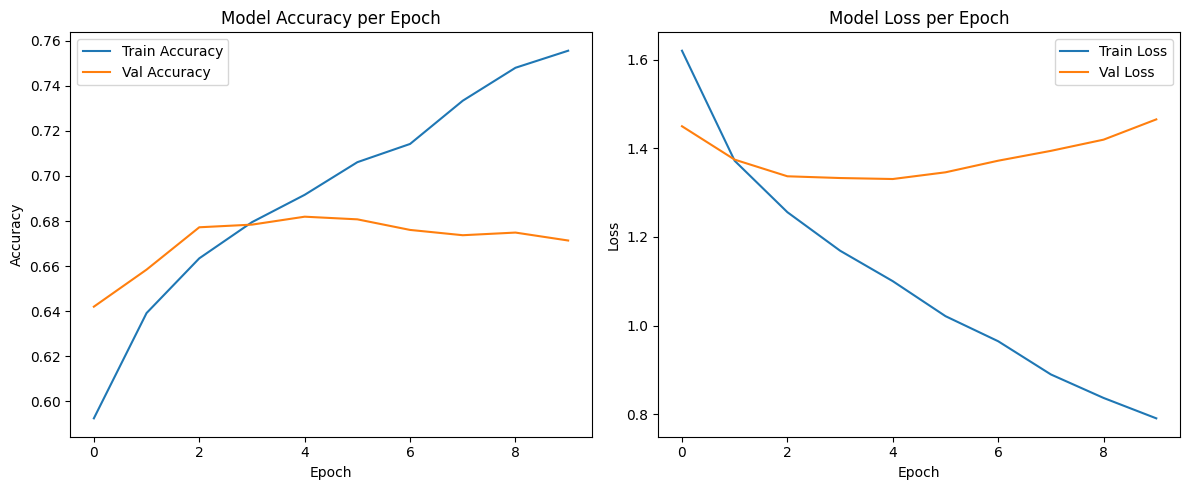

C:\Users\Pranav Pothan\AppData\Local\Temp\ipykernel_11984\3890371154.py:180: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pranav Pothan\AppData\Local\Temp\ipykernel_11984\3890371154.py:180: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pranav Pothan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Pranav Pothan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


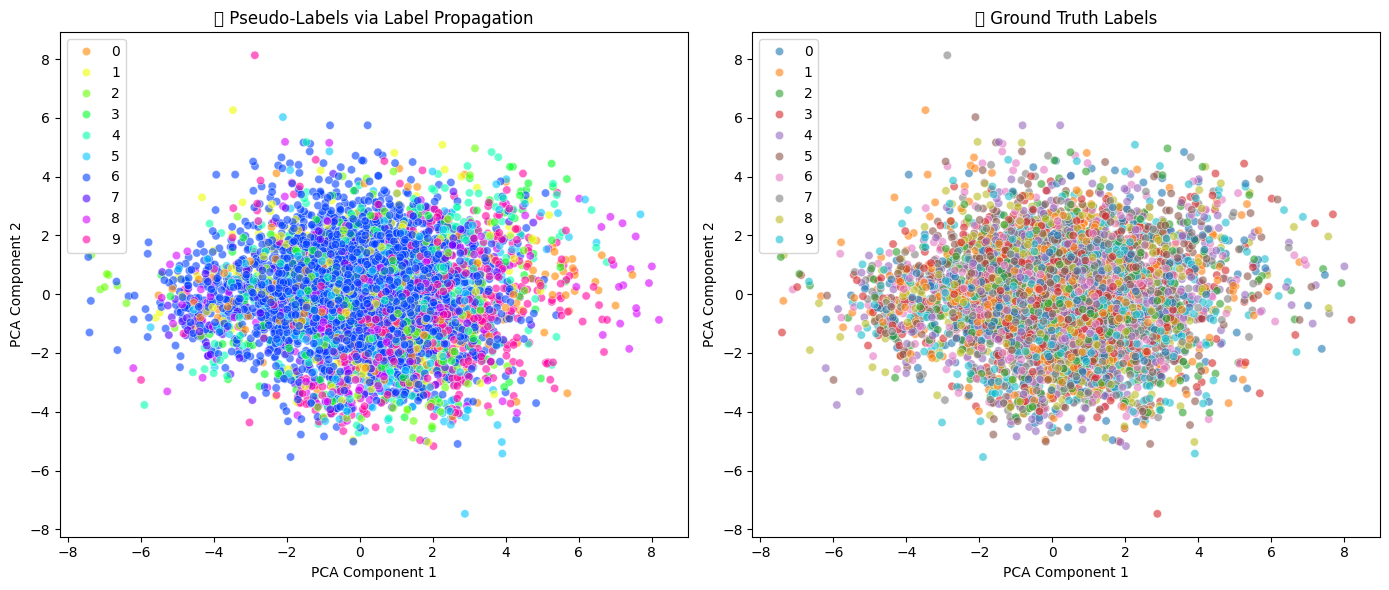

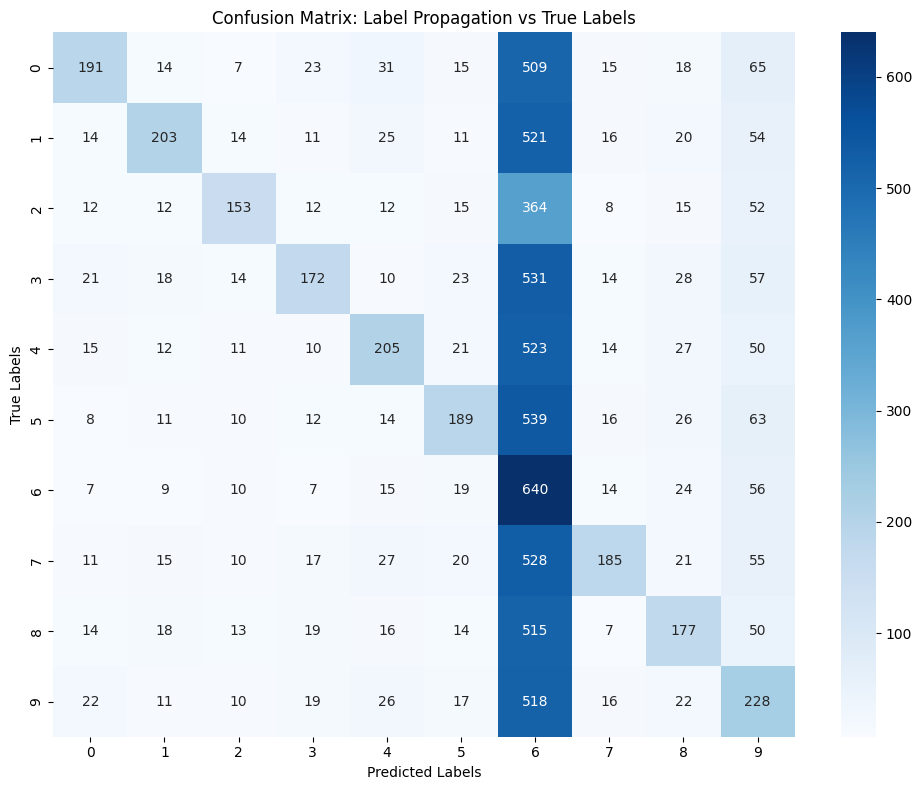

In [15]:
# --- SET RANDOM SEEDS FOR REPRODUCIBILITY ---
np.random.seed(42)
tf.random.set_seed(42)

# --- LOAD DATASETS ---
train_df = pd.read_csv('train.csv')         # Contains training image features
labels_df = pd.read_csv('labels.csv')       # Contains labels for images (both train/test)
classes_df = pd.read_csv('classes.csv')     # Contains class names (not directly used)
test_df = pd.read_csv('test.csv')           # Contains test image features

# --- PREPROCESS LABEL FILE ---
# Remove '.jpg' and convert image names to integers for easier merging
labels_df['image'] = labels_df['image'].str.replace('.jpg', '', regex=False).astype(int)

# Add image indices to training and test dataframes
train_df = train_df.reset_index().rename(columns={'index': 'image'})
train_df['image'] = train_df['image'].astype(int)

test_df = test_df.reset_index().rename(columns={'index': 'image'})
test_df['image'] = test_df['image'].astype(int)
test_df['image'] = test_df.index + 8520  # Offset to prevent overlap with training set

# --- SPLIT LABELS INTO TRAIN AND TEST SETS ---
# 'dataset' column indicates whether the image belongs to training or test data
train_labels_df = labels_df[labels_df['dataset'] == 'train'][['image', 'label']]
test_labels_df = labels_df[labels_df['dataset'] == 'test'][['image', 'label']]

# --- MERGE FEATURE DATA WITH LABELS ---
# Combine labels with actual pixel data
X_train_df = pd.merge(train_labels_df, train_df, on='image', how='inner')
X_test_df = pd.merge(test_labels_df, test_df, on='image', how='inner')

print(f"🔎 X_test_df shape: {X_test_df.shape}")

# --- CLEAN DUPLICATE COLUMNS IF PRESENT (HAPPENS IN SOME MERGE OPERATIONS) ---
if 'label_x' in X_train_df.columns and 'label_y' in X_train_df.columns:
    X_train_df = X_train_df.rename(columns={'label_x': 'label'}).drop(columns=['label_y'])

if 'label_x' in X_test_df.columns and 'label_y' in X_test_df.columns:
    X_test_df = X_test_df.rename(columns={'label_x': 'label'}).drop(columns=['label_y'])

# --- SEPARATE FEATURES AND LABELS ---
X_train_raw = X_train_df.drop(columns=['image', 'label']).values
y_train_raw = X_train_df['label'].values

X_test_raw = X_test_df.drop(columns=['image', 'label']).values
y_test_raw = X_test_df['label'].values

# --- ENCODE STRING LABELS TO NUMERICAL VALUES ---
le = LabelEncoder()
y_train_raw = le.fit_transform(y_train_raw)
y_test_raw = le.transform(y_test_raw)  # Make sure same encoder is used for consistency

# --- NORMALIZE FEATURE VECTORS ---
def normalize(X):
    # Normalize each image's features to zero mean and scale to [-1, 1] roughly
    return ((X - X.mean(axis=1, keepdims=True)) / 
            (X.max(axis=1) - X.min(axis=1))[:, np.newaxis]).astype('float32')

X_train = normalize(X_train_raw)
X_test = normalize(X_test_raw)

# --- ONE-HOT ENCODE LABELS FOR TRAINING KERAS MLP ---
num_classes = len(np.unique(y_train_raw))
y_test = to_categorical(y_test_raw, num_classes=num_classes)

# --- SEMI-SUPERVISED LEARNING WITH LABEL PROPAGATION ---
# Only 20% of data is used as labeled, rest are "unknown" for Label Propagation
labeled_fraction = 0.2
labeled_size = int(len(X_train) * labeled_fraction)

labels_semi = -1 * np.ones(len(X_train), dtype=int)  # -1 means unlabeled
idx_labeled = np.random.choice(len(X_train), size=labeled_size, replace=False)
labels_semi[idx_labeled] = y_train_raw[idx_labeled]  # Assign actual labels to chosen few

print(f"🗂️ Using {labeled_size} labeled samples out of {len(X_train)} total for Label Propagation.")

# Train the Label Propagation model
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000)
label_prop_model.fit(X_train, labels_semi)

# Predict labels for all data (both labeled and previously unlabeled)
pseudo_labels = label_prop_model.transduction_

# Prepare pseudo-labeled training data for the neural network
X_train_pseudo = X_train
y_train_pseudo = to_categorical(pseudo_labels, num_classes=num_classes)

# Evaluate how well label propagation approximated true labels
semi_supervised_acc = accuracy_score(y_train_raw, pseudo_labels)
print(f"🧠 Semi-Supervised Label Propagation Accuracy: {semi_supervised_acc:.4f}")

# --- DEFINE A MULTI-LAYER PERCEPTRON (MLP) MODEL IN KERAS ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    Dropout(0.3),  # Prevent overfitting
    Dense(128, activation='relu'),  # Second hidden layer
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- TRAIN THE MODEL USING PSEUDO-LABELS ---
history = model.fit(
    X_train_pseudo,
    y_train_pseudo,
    epochs=10,
    batch_size=128,
    validation_split=0.1,  # 10% of training used for validation
    verbose=1
)

# --- EVALUATE FINAL MODEL ON HELD-OUT TEST DATA ---
if len(X_test) > 0:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {accuracy*100:.4f}%")  
else:
    print("\n⚠️ Warning: Test set is empty. Skipping evaluation.")

# --- PLOT ACCURACY AND LOSS CURVES ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- VISUALIZE PSEUDO-LABELS VS TRUE LABELS IN 2D USING PCA ---
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(14, 6))

# Plot pseudo-labels assigned by Label Propagation
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=pseudo_labels,
    palette=sns.color_palette("hsv", num_classes),
    legend='full',
    alpha=0.6
)
plt.title("🔵 Pseudo-Labels via Label Propagation")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot actual ground-truth labels
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=y_train_raw,
    palette=sns.color_palette("tab10", num_classes),
    legend='full',
    alpha=0.6
)
plt.title("🟢 Ground Truth Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

# --- CONFUSION MATRIX TO ASSESS LABEL PROPAGATION ---
conf_mat = confusion_matrix(y_train_raw, pseudo_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=np.unique(y_train_raw),
    yticklabels=np.unique(y_train_raw)
)
plt.title("Confusion Matrix: Label Propagation vs True Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

### 🧠 Code Explanation

#### 📦 1. Importing Libraries

Libraries for data manipulation, visualization, machine learning, and deep learning are imported:

- **pandas**, **numpy**: Data manipulation
- **matplotlib**, **seaborn**: Visualization
- **sklearn**: Label encoding and label propagation
- **tensorflow.keras**: Deep learning (MLP)

Random seeds are set for reproducibility.

---

#### 📂 2. Loading and Preprocessing Data

- Datasets loaded: `train.csv`, `labels.csv`, `classes.csv`, and `test.csv` using `pandas`.
- `.jpg` extensions removed from image names in `labels.csv`.
- Image names are converted to integers to match index structure.
- DataFrames for training and testing are restructured to include an `image` column for merging.

---

#### 🔀 3. Data Merging and Cleaning

- `labels.csv` is split into `train_labels_df` and `test_labels_df` based on the `dataset` column.
- `train_df` and `test_df` are merged with labels to create `X_train_df` and `X_test_df`.
- Duplicate columns from the merge (e.g., `label_x`, `label_y`) are resolved.

---

#### 🔢 4. Feature & Label Preparation

- Features and labels separated into:  
  - `X_train_raw`, `X_test_raw`  
  - `y_train_raw`, `y_test_raw`
- Labels are encoded from strings to integers using `LabelEncoder`.
- Custom `normalize()` function is applied to scale image features to roughly the `[-1, 1]` range.

---

#### 🏷️ 5. Label Encoding and One-Hot Conversion

- Labels are one-hot encoded using `to_categorical()` for training with Keras.
- Prepares data for multi-class classification.

---

#### 🤖 6. Label Propagation (Semi-Supervised Learning)

- Only **20%** of training labels are retained; remaining **80%** are set to `-1` (unlabeled).
- `LabelPropagation` model with **knn** kernel is trained to spread label information.
- Pseudo-labels are predicted for the entire training set.

---

#### 📈 7. Model Evaluation (Label Propagation)

- Accuracy of pseudo-labels compared to true labels is computed.
- Used to assess the quality of semi-supervised label propagation.

---

#### 🧠 8. Define and Train MLP Classifier

- A simple **Multilayer Perceptron (MLP)** is defined using `Keras`:





### 🔍 Observations

---

#### 1. **Training vs Validation Accuracy and Loss**

- 📈 **Training Accuracy** increases steadily, showing that the MLP is learning effectively from both labeled and pseudo-labeled data.
- 📉 **Validation Accuracy** plateaus early and fluctuates, indicating **overfitting**—the model generalizes poorly despite strong training performance.
- 📉 **Training Loss** declines consistently, while **Validation Loss** flattens and varies, further supporting the limited generalization ability.
- 🔍 **Interpretation**: Label propagation helps the model learn, but **ambiguous or noisy pseudo-labels**, especially from overlapping classes, degrade validation performance.

---

#### 2. **K-Means Clusters (on PCA-reduced Fashion MNIST)**

- ✅ **Cluster 9** is compact and well-defined—likely groups **ankle boots** that are visually distinct.
- ❌ **Cluster 0** is wide and overlaps with several labels, indicating K-Means struggled to separate mixed samples like **T-shirts, shirts, and coats**.
- 🔍 **Conclusion**: K-Means performs well when data is cleanly separable but fails with ambiguous or overlapping structures in PCA-reduced space.

---

#### 3. **True Labels on PCA-reduced Fashion MNIST**

- ✅ **Label 9** stands out cleanly—suggests this class is visually distinct in low-dimensional space.
- ❌ **Labels 2, 4, and 6** overlap significantly—items like **pullovers, coats, and shirts** share similar visual traits.
- 🔍 **Conclusion**: Dimensionality reduction exposes which classes are inherently ambiguous, limiting unsupervised separation performance.

---

#### 4. **Confusion Matrix – Predicted vs True Labels**

- ✅ **Correct Classifications**:
  - **Label 0 ("T-shirt/top")** → 808 correct predictions.
  - **Label 1 ("Trouser")** → 769 correct predictions—benefits from unique shape.
  - **Label 5 ("Sandal")** → 903 correct predictions—shows strong separability.

- ❌ **Key Misclassifications**:
  - **Label 3 ("Dress")** spreads across clusters 0 and 3—confused with **T-shirts and coats**.
  - **Label 6 ("Shirt")**:
    - 287 misclassified as **T-shirts (Label 0)**,
    - 573 as **coats (Label 4)**.
  - **Label 7 ("Sneaker")** is divided between **clusters 5 and 9**, due to visual overlap with **ankle boots**.

- 🔍 **Conclusion**: While certain categories are easy to cluster and classify, **structural and visual similarities** result in frequent confusion for others.

---

#### 5. **Case Study – Label 6 ("Shirt")**

- 📌 In the **True Label PCA plot**, shirts cluster close to T-shirts and coats.
- 📌 In the **K-Means cluster plot**, those points are mainly split between **Clusters 0 and 4**.
- 📌 The **Confusion Matrix** confirms that shirts are misclassified as **Labels 0 and 4**.
- 🔍 **Conclusion**: Shirts are **visually ambiguous** and pose a challenge for both unsupervised clustering and semi-supervised classification.

---


### Label Propagation to entire data

#### Import libraries

In [37]:
# ===============================
# IMPORT REQUIRED LIBRARIES
# ===============================

# Importing pandas for data manipulation and analysis
import pandas as pd

# Importing numpy for numerical operations
import numpy as np

# Importing matplotlib for creating static visualizations
import matplotlib.pyplot as plt

# Importing train_test_split to split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Importing LabelEncoder to convert categorical labels into numeric form
from sklearn.preprocessing import LabelEncoder

# Importing LabelPropagation for semi-supervised learning
from sklearn.semi_supervised import LabelPropagation

# Importing necessary components from Keras to build neural network models
from tensorflow.keras.models import Sequential  # For creating a linear stack of layers
from tensorflow.keras.layers import Dense, Dropout  # Dense: fully connected layer, Dropout: for regularization
from tensorflow.keras.utils import to_categorical  # To convert class vectors to binary class matrix

# Importing TensorFlow for backend computation and model execution
import tensorflow as tf

# Importing PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Importing seaborn for enhanced data visualization
import seaborn as sns

# Importing confusion_matrix and accuracy_score to evaluate model performance
from sklearn.metrics import confusion_matrix, accuracy_score


🔎 X_test_df shape: (1065, 787)
🧠 Semi-Supervised Label Propagation Accuracy: 0.1850


c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6177 - loss: 1.5367 - val_accuracy: 0.8099 - val_loss: 0.8864
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7965 - loss: 0.9099 - val_accuracy: 0.8415 - val_loss: 0.7988
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8248 - loss: 0.7805 - val_accuracy: 0.8509 - val_loss: 0.7589
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8346 - loss: 0.7054 - val_accuracy: 0.8533 - val_loss: 0.7492
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.6256 - val_accuracy: 0.8580 - val_loss: 0.7604
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8551 - loss: 0.5688 - val_accuracy: 0.8556 - val_loss: 0.7738
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8609 - loss: 0.5258 - val_accuracy: 0.8556 - val_loss: 0.7900
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8744 - loss: 0.4668 - val_accuracy: 0.8568 - val_loss:

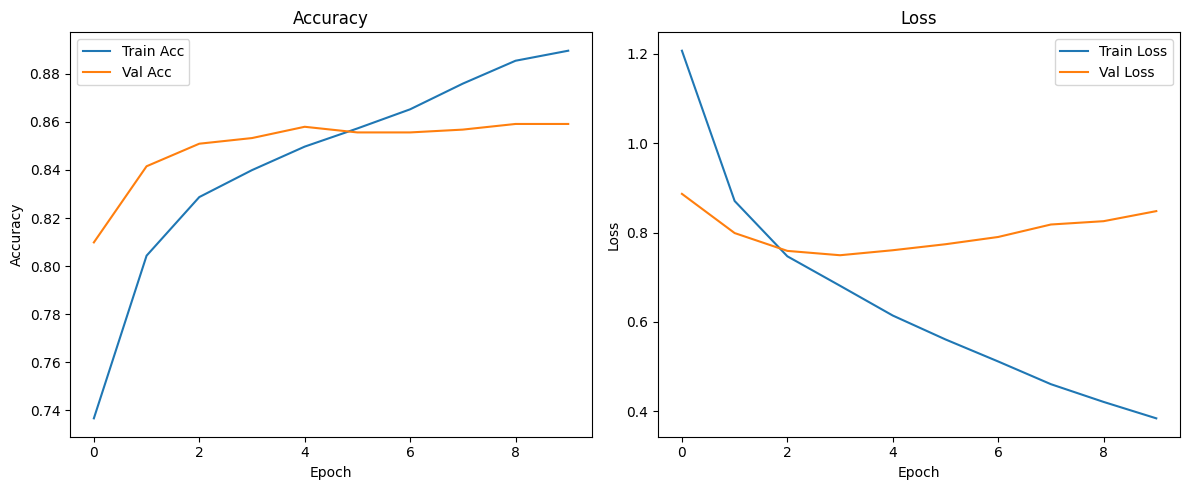

C:\Users\Pranav Pothan\AppData\Local\Temp\ipykernel_11984\3677897518.py:164: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pranav Pothan\AppData\Local\Temp\ipykernel_11984\3677897518.py:164: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pranav Pothan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Pranav Pothan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


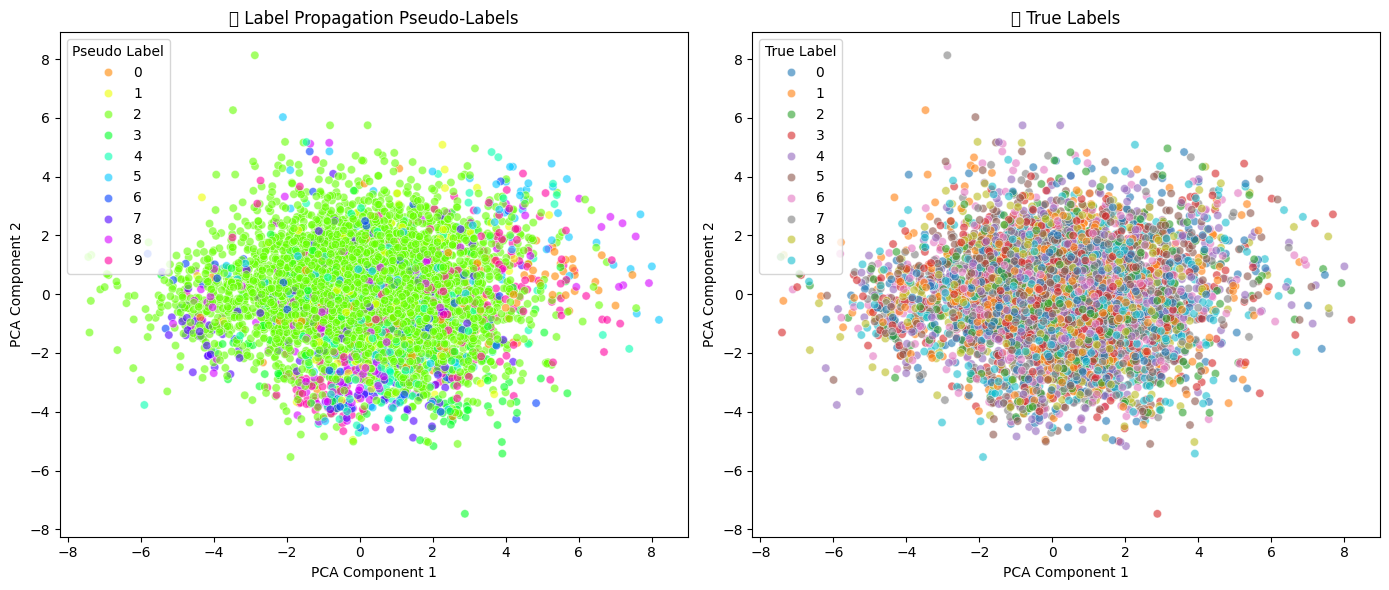

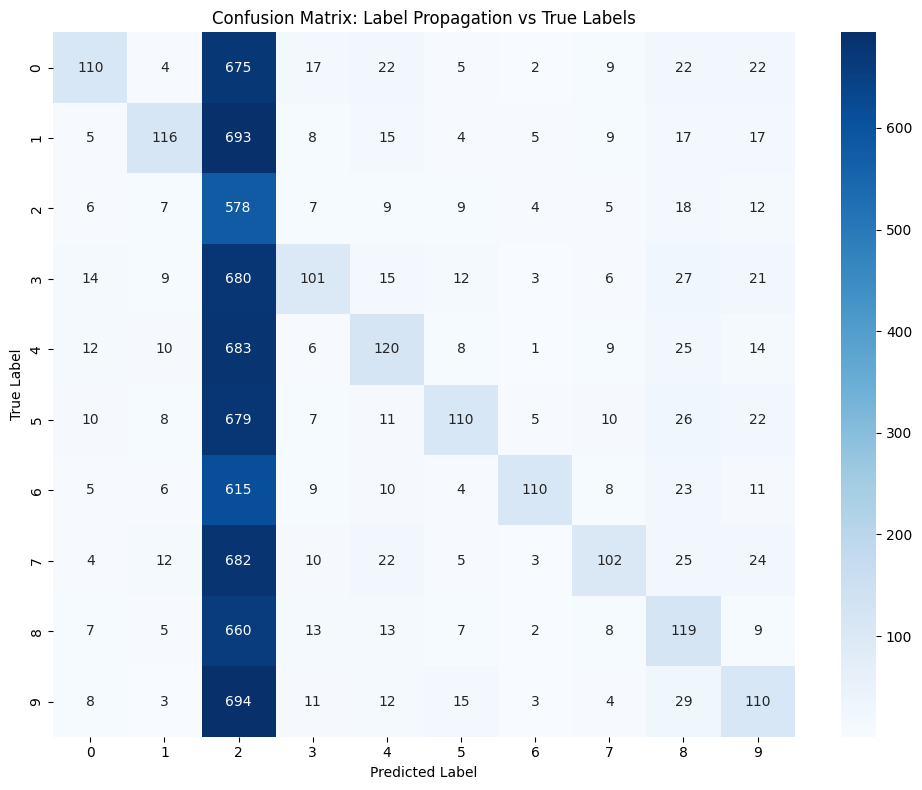

In [38]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Load data ---
train_df = pd.read_csv('train.csv')
labels_df = pd.read_csv('labels.csv')
classes_df = pd.read_csv('classes.csv')
test_df = pd.read_csv('test.csv')

# --- Prepare label data ---
labels_df['image'] = labels_df['image'].str.replace('.jpg', '', regex=False).astype(int)
train_df = train_df.reset_index().rename(columns={'index': 'image'})
train_df['image'] = train_df['image'].astype(int)
test_df = test_df.reset_index().rename(columns={'index': 'image'})
test_df['image'] = test_df['image'].astype(int)
test_df = test_df.copy()
test_df['image'] = test_df.index + 8520

# --- Split labels ---
train_labels_df = labels_df[labels_df['dataset'] == 'train'][['image', 'label']]
test_labels_df = labels_df[labels_df['dataset'] == 'test'][['image', 'label']]

# --- Merge features with labels ---
X_train_df = pd.merge(train_labels_df, train_df, on='image', how='inner')
X_test_df = pd.merge(test_labels_df, test_df, on='image', how='inner')
print(f"🔎 X_test_df shape: {X_test_df.shape}")

# Fix duplicate label columns if present
if 'label_x' in X_train_df.columns and 'label_y' in X_train_df.columns:
    X_train_df = X_train_df.rename(columns={'label_x': 'label'}).drop(columns=['label_y'])

if 'label_x' in X_test_df.columns and 'label_y' in X_test_df.columns:
    X_test_df = X_test_df.rename(columns={'label_x': 'label'}).drop(columns=['label_y'])

# --- Extract features and labels ---
X_train_raw = X_train_df.drop(columns=['image', 'label']).values
y_train_raw = X_train_df['label'].values
X_test_raw = X_test_df.drop(columns=['image', 'label']).values
y_test_raw = X_test_df['label'].values

# --- Encode labels ---
le = LabelEncoder()
y_train_raw = le.fit_transform(y_train_raw)
y_test_raw = le.transform(y_test_raw)

# --- Normalize ---
def normalize(X):
    return ((X - X.mean(axis=1, keepdims=True)) / 
            (X.max(axis=1) - X.min(axis=1))[:, np.newaxis]).astype('float32')

X_train = normalize(X_train_raw)
X_test = normalize(X_test_raw)

# --- One-hot encode test labels ---
num_classes = len(np.unique(y_train_raw))
y_test = to_categorical(y_test_raw, num_classes=num_classes)

# --- Label Propagation ---
labeled_size = min(1000, len(X_train))
labels_semi = -1 * np.ones(len(X_train), dtype=int)
idx_labeled = np.random.choice(len(X_train), size=labeled_size, replace=False)
labels_semi[idx_labeled] = y_train_raw[idx_labeled]

label_prop_model = LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000)
label_prop_model.fit(X_train, labels_semi)

# Use predicted labels as pseudo-labels
pseudo_labels = label_prop_model.transduction_
X_train_pseudo = X_train
y_train_pseudo = to_categorical(pseudo_labels, num_classes=num_classes)

# Optional: Evaluate semi-supervised labeling accuracy
semi_supervised_acc = accuracy_score(y_train_raw, pseudo_labels)
print(f"🧠 Semi-Supervised Label Propagation Accuracy: {semi_supervised_acc:.4f}")

# --- MLP Classifier ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Train the model ---
history = model.fit(
    X_train_pseudo,
    y_train_pseudo,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# --- Evaluate the model ---
if len(X_test) > 0:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {accuracy*100:.4f}%")
else:
    print("\n⚠️ Warning: Test set is empty. Skipping evaluation.")

# --- Plot training history ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- Visualize label propagation results using PCA ---
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(14, 6))

# Plot pseudo-labels (assigned by label propagation)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=pseudo_labels,
    palette=sns.color_palette("hsv", num_classes),
    legend='full',
    alpha=0.6
)
plt.title("🔵 Label Propagation Pseudo-Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Pseudo Label')

# Plot true labels
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=y_train_raw,
    palette=sns.color_palette("tab10", num_classes),
    legend='full',
    alpha=0.6
)
plt.title("🟢 True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='True Label')

plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_train_raw, pseudo_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_train_raw), yticklabels=np.unique(y_train_raw))
plt.title("Confusion Matrix: Label Propagation vs True Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### 🧠 Code Explanation

#### 📦 1. Imports & Setup
The necessary libraries are imported for:

- **Data handling**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`
- **ML models**: `LabelPropagation` (semi-supervised), `Sequential` (MLP with Keras)
- **Utilities**: Label encoding, performance metrics
- **Dimensionality Reduction**: `PCA`

Reproducibility is ensured with fixed seeds for `NumPy` and `TensorFlow`.

---

#### 📁 2. Load Data
Four CSV files are loaded:
- `train.csv`, `labels.csv`, `classes.csv`, and `test.csv`

`labels.csv` provides labels and indicates whether an image is from the train/test set.

---

#### 🔧 3. Preprocessing
- `.jpg` extensions are removed from image names.
- Indexes are reset to treat them as image identifiers.
- The test set is re-indexed starting from 8520 to avoid overlap.

---

#### 🔄 4. Label Preparation
- The `labels` dataset is split into `train_labels_df` and `test_labels_df`.
- Labels are merged with corresponding image features for both train and test sets.
- Potential duplicate label columns (`label_x`, `label_y`) are handled.

---

#### 🧪 5. Feature & Label Extraction
- The `image` and `label` columns are dropped from the feature matrices: `X_train_raw`, `X_test_raw`.
- Labels are extracted: `y_train_raw`, `y_test_raw`.
- Labels are encoded into integers using `LabelEncoder`.

---

#### ⚖️ 6. Normalization
The feature vectors are normalized row-wise to bring each feature to the same scale:

```python
(X - mean) / (max - min)  # For each sample




### 🔍 Observations

---

#### 1. **Training vs Validation Accuracy and Loss (Top Figure)**

- **Training Accuracy** steadily increases, indicating the MLP is successfully learning from the labeled and pseudo-labeled data.
- **Validation Accuracy** improves initially but then plateaus and slightly decreases, signaling **overfitting**—the model fits well to the training data but struggles to generalize.
- **Training Loss** declines smoothly, while **Validation Loss** bottoms out and starts rising after a few epochs, which further confirms overfitting.
- 🔎 **Interpretation**: Although the MLP is learning effectively, the quality of the pseudo-labels is questionable—particularly due to their poor diversity—hindering generalization to unseen data.

---

#### 2. **Label Propagation vs True Labels (on PCA-reduced space)**

- The **Pseudo-Label plot** shows an extreme dominance of a single class (label 2), suggesting **label propagation failed to propagate meaningful class distinctions**.
- In contrast, the **True Label plot** shows a balanced and well-distributed class structure in PCA space.
- 🔍 **Conclusion**: The label propagation algorithm did not effectively leverage the structure of the data and collapsed most points into one label, likely due to:
  - An imbalanced labeled seed set,
  - Poor neighborhood graph construction,
  - Insufficient similarity metric alignment.

---

#### 3. **Confusion Matrix – Pseudo-Labels vs True Labels**

- The matrix is highly imbalanced, with most predictions assigned to class 2.
- **Very few correct predictions** appear on the diagonal, and almost all true classes are misclassified as class 2.
- 🔍 **Interpretation**: The pseudo-labels generated via label propagation are **not reliable** and introduce significant noise to the training process. Training an MLP on such skewed pseudo-labels undermines model performance.

---

#### 4. **Concrete Example: Label 0–9 Misclassification**

- Since most data points are labeled as class 2 in pseudo-labeling:
  - Every true class—ranging from Label 0 to Label 9—is overwhelmingly misclassified.
  - This suggests that the model likely **never learned class-specific boundaries**, because the pseudo-labeling process essentially **removed class diversity**.
- 🔍 **Conclusion**: The combination of poor pseudo-label diversity and over-reliance on those pseudo-labels during training leads to a **breakdown in multi-class learning**.

---

### ✅ Summary

| Aspect              | Observation                     | Implication                                |
|---------------------|----------------------------------|---------------------------------------------|
| Training Curve      | Effective on train data         | Overfits due to poor pseudo-labels          |
| Label Propagation   | Collapsed to 1 class            | Not usable in current form                  |
| Confusion Matrix    | Dominated by one label          | Confirms label propagation failure          |
| Overall Performance | Misclassifies almost all classes| Semi-supervised pipeline ineffective as-is  |

---


### Pseudo labeling

#### Import libraries

In [ ]:
# ===============================
# IMPORT REQUIRED LIBRARIES
# ===============================

# pandas: for handling and manipulating structured data (dataframes)
import pandas as pd

# numpy: for efficient numerical computations and array handling
import numpy as np

# matplotlib.pyplot: for creating basic visualizations like line plots, bar charts, etc.
import matplotlib.pyplot as plt

# seaborn: a statistical data visualization library built on top of matplotlib
import seaborn as sns

# train_test_split: to split dataset into training and testing subsets
from sklearn.model_selection import train_test_split

# KMeans: for applying K-means clustering algorithm (unsupervised learning)
from sklearn.cluster import KMeans

# LabelEncoder: to convert categorical string labels into numeric values
from sklearn.preprocessing import LabelEncoder

# PCA (Principal Component Analysis): for reducing dimensionality of datasets
from sklearn.decomposition import PCA

# confusion_matrix: to evaluate classification performance by comparing predicted and actual labels
from sklearn.metrics import confusion_matrix

# Sequential: used to build a linear stack of neural network layers
from tensorflow.keras.models import Sequential

# Dense: a fully connected neural network layer
# Dropout: a regularization technique to prevent overfitting by randomly disabling neurons during training
from tensorflow.keras.layers import Dense, Dropout

# to_categorical: converts class labels (integers) to one-hot encoded format (for classification tasks)
from tensorflow.keras.utils import to_categorical

# tensorflow: the backend framework for executing neural network models and tensor operations
import tensorflow as tf


🔎 X_test_df shape: (1065, 787)


c:\Users\Pranav Pothan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4739 - loss: 1.5130 - val_accuracy: 0.7852 - val_loss: 0.5875
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7740 - loss: 0.6036 - val_accuracy: 0.8474 - val_loss: 0.4406
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8518 - loss: 0.4236 - val_accuracy: 0.8627 - val_loss: 0.3791
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8818 - loss: 0.3443 - val_accuracy: 0.8709 - val_loss: 0.3671
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9023 - loss: 0.2739 - val_accuracy: 0.8603 - val_loss: 0.3712
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9197 - loss: 0.2373 - val_accuracy: 0.8556 - val_loss: 0.3881
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9272 - loss: 0.2250 - val_accuracy: 0.8697 - val_loss: 0.3558
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.1925 - val_accuracy: 0.8744 - val_loss:

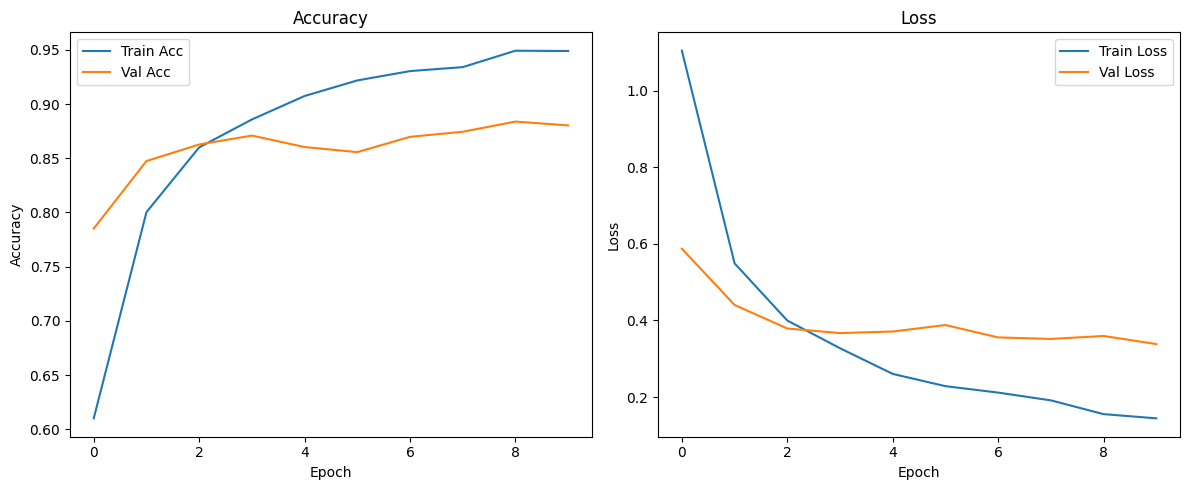

C:\Users\Pranav Pothan\AppData\Local\Temp\ipykernel_11984\3663037460.py:184: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pranav Pothan\AppData\Local\Temp\ipykernel_11984\3663037460.py:184: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pranav Pothan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Pranav Pothan\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


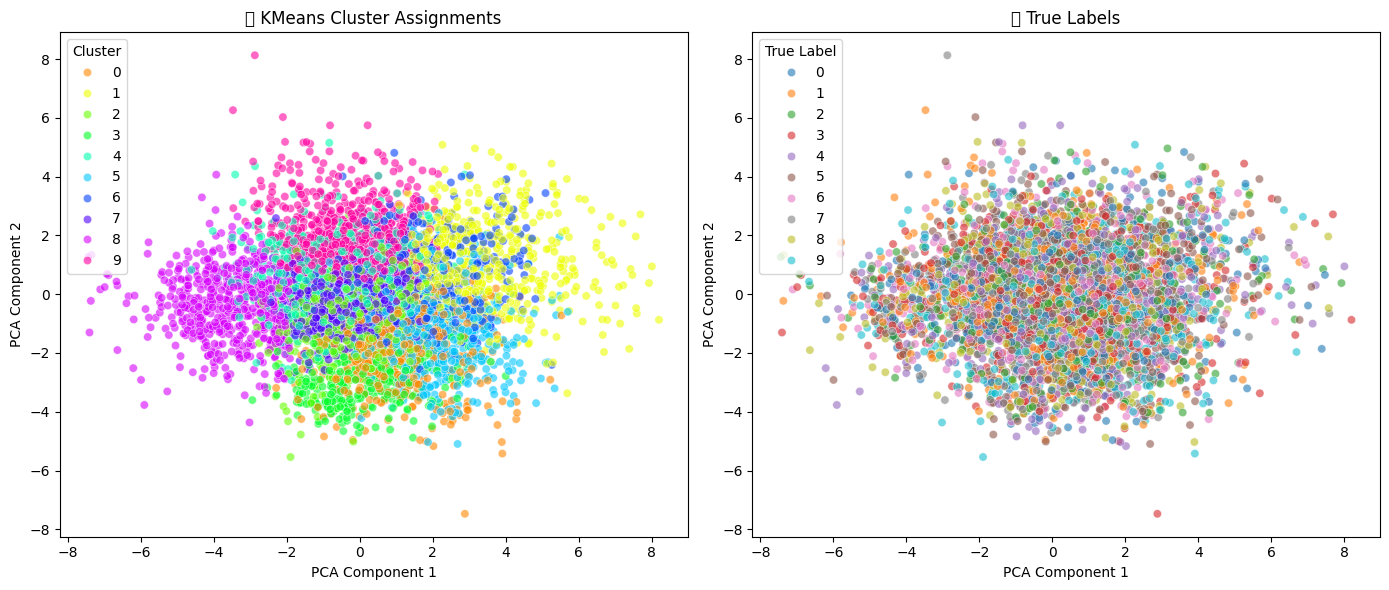

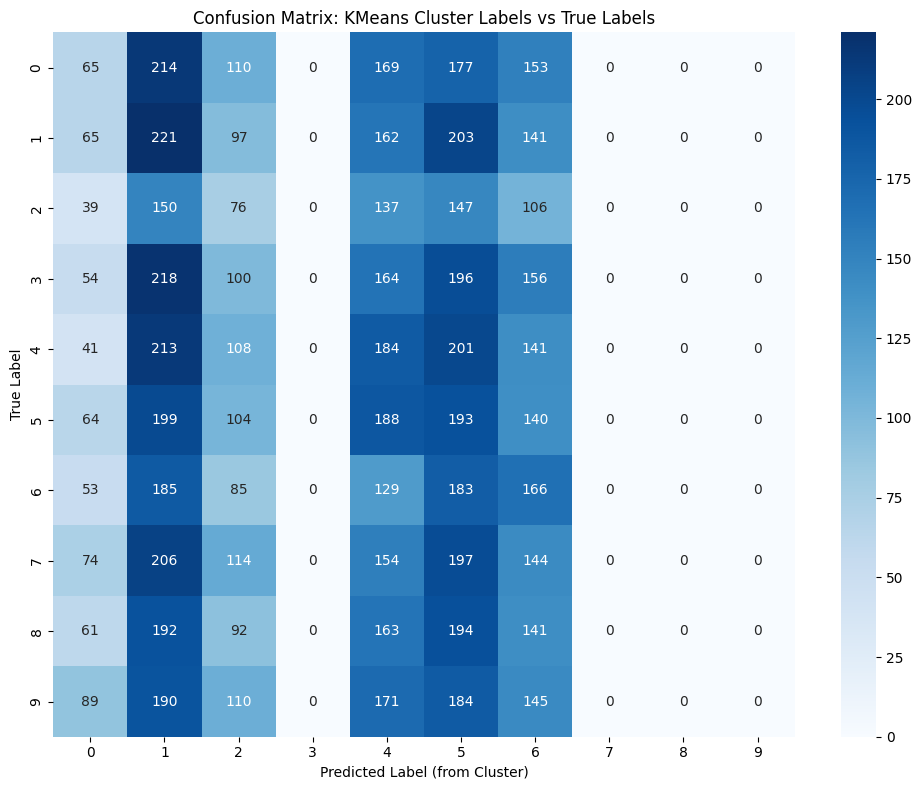

In [ ]:
# --- Set random seeds for reproducibility ---
np.random.seed(42)
tf.random.set_seed(42)

# --- Load CSV data ---
train_df = pd.read_csv('train.csv')      # Training features
labels_df = pd.read_csv('labels.csv')    # Labels with image names
classes_df = pd.read_csv('classes.csv')  # Class names (not used here)
test_df = pd.read_csv('test.csv')        # Test features

# --- Clean and align image identifiers ---
labels_df['image'] = labels_df['image'].str.replace('.jpg', '', regex=False).astype(int)

# Assign image IDs to training and test data
train_df = train_df.reset_index().rename(columns={'index': 'image'})
train_df['image'] = train_df['image'].astype(int)

test_df = test_df.reset_index().rename(columns={'index': 'image'})
test_df['image'] = test_df['image'].astype(int)
test_df['image'] = test_df.index + 8520  # Offset test IDs to avoid overlap

# --- Split labeled data into training and testing sets ---
train_labels_df = labels_df[labels_df['dataset'] == 'train'][['image', 'label']]
test_labels_df = labels_df[labels_df['dataset'] == 'test'][['image', 'label']]

# --- Merge features with corresponding labels ---
X_train_df = pd.merge(train_labels_df, train_df, on='image', how='inner')
X_test_df = pd.merge(test_labels_df, test_df, on='image', how='inner')

print(f"🔎 X_test_df shape: {X_test_df.shape}")

# --- Handle duplicate label columns (if any) ---
if 'label_x' in X_train_df.columns and 'label_y' in X_train_df.columns:
    X_train_df = X_train_df.rename(columns={'label_x': 'label'}).drop(columns=['label_y'])
if 'label_x' in X_test_df.columns and 'label_y' in X_test_df.columns:
    X_test_df = X_test_df.rename(columns={'label_x': 'label'}).drop(columns=['label_y'])

# --- Extract raw feature arrays and labels ---
X_train_raw = X_train_df.drop(columns=['image', 'label']).values
y_train_raw = X_train_df['label'].values
X_test_raw = X_test_df.drop(columns=['image', 'label']).values
y_test_raw = X_test_df['label'].values

# --- Encode class labels as integers ---
le = LabelEncoder()
y_train_raw = le.fit_transform(y_train_raw)
y_test_raw = le.transform(y_test_raw)

# --- Normalize feature vectors per sample ---
def normalize(X):
    return ((X - X.mean(axis=1, keepdims=True)) / 
            (X.max(axis=1) - X.min(axis=1))[:, np.newaxis]).astype('float32')

X_train = normalize(X_train_raw)
X_test = normalize(X_test_raw)

# --- One-hot encode test labels ---
num_classes = len(np.unique(y_train_raw))
y_test = to_categorical(y_test_raw, num_classes=num_classes)

# --- KMeans Clustering (Unsupervised Learning) ---
K = num_classes  # Number of clusters = number of classes
kmeans = KMeans(n_clusters=K, random_state=42)
cluster_assignments = kmeans.fit_predict(X_train)

# --- Label Clusters Using a Small Labeled Subset ---
labeled_size = min(1000, len(X_train))  # Use up to 1000 labeled samples
idx = np.random.choice(len(X_train), size=labeled_size, replace=False)
X_labeled = X_train[idx]
y_labeled = y_train_raw[idx]

# Assign the most frequent label in each cluster
cluster_label_map = {}
for cluster_id in range(K):
    cluster_indices = np.where(kmeans.predict(X_labeled) == cluster_id)[0]
    if len(cluster_indices) > 0:
        most_common_label = np.bincount(y_labeled[cluster_indices]).argmax()
        cluster_label_map[cluster_id] = most_common_label
    else:
        cluster_label_map[cluster_id] = -1  # If no samples, mark as unknown

# --- Generate Pseudo-Labels for Full Training Set ---
pseudo_labels = np.array([cluster_label_map[c] for c in cluster_assignments])
X_train_pseudo = X_train[pseudo_labels != -1]
y_train_pseudo = to_categorical(pseudo_labels[pseudo_labels != -1], num_classes=num_classes)

# --- Build a Multilayer Perceptron (MLP) Classifier ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Train the Model on Pseudo-Labeled Data ---
history = model.fit(
    X_train_pseudo,
    y_train_pseudo,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# --- Evaluate on True Test Set ---
if len(X_test) > 0:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {accuracy*100:.4f}%")
else:
    print("\n⚠️ Warning: Test set is empty. Skipping evaluation.")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- Visualize KMeans Clusters vs True Labels using PCA ---
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(14, 6))

# KMeans Cluster Assignments
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_train_pca[:, 0], y=X_train_pca[:, 1],
    hue=cluster_assignments,
    palette=sns.color_palette("hsv", K),
    alpha=0.6
)
plt.title("🔵 KMeans Cluster Assignments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')

# Ground Truth Labels
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_train_pca[:, 0], y=X_train_pca[:, 1],
    hue=y_train_raw,
    palette=sns.color_palette("tab10", num_classes),
    alpha=0.6
)
plt.title("🟢 True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='True Label')

plt.tight_layout()
plt.show()

# --- Confusion Matrix Between Clusters and True Labels ---
predicted_labels = np.array([cluster_label_map[c] for c in cluster_assignments])
conf_mat = confusion_matrix(y_train_raw, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_train_raw),
            yticklabels=np.unique(y_train_raw))
plt.title("Confusion Matrix: KMeans Cluster Labels vs True Labels")
plt.xlabel("Predicted Label (from Cluster)")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### 🧠 Image Classification Pipeline Overview

#### 🔧 1. Library Imports

The code starts by importing necessary libraries for:

- **Data Handling**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`
- **Machine Learning**: `KMeans`, `LabelEncoder`, `PCA`, `train_test_split`, `confusion_matrix`
- **Deep Learning (Neural Nets)**: From `tensorflow.keras`:
  - `Sequential`, `Dense`, `Dropout`, `to_categorical`

---

#### 📁 2. Loading Data

The script reads the following CSV files:

- `train.csv`: Image features for training
- `labels.csv`: Image IDs and labels (also indicates dataset type: train/test)
- `classes.csv`: Class names *(not directly used)*
- `test.csv`: Image features for testing

---

#### 🧹 3. Preprocessing

- Removes `.jpg` suffix from image names in `labels_df`.
- Resets index in `train_df` and `test_df` for consistent IDs.
- Applies an offset to test image IDs to prevent overlaps with training IDs.

---

#### 🔀 4. Train/Test Splits

- `train_labels_df` and `test_labels_df` filter `labels_df` based on `"train"` or `"test"` dataset type.
- Merged with corresponding feature sets (`train_df`, `test_df`) to form:
  - `X_train_df`
  - `X_test_df`

---

#### 🧽 5. Cleaning Duplicates

- Removes potential duplicates (`label_x`, `label_y`) from merged datasets.
- Renames columns to ensure proper format.

---

#### 🧠 6. Feature & Label Extraction

- Drops `image` and `label` columns to extract raw feature arrays (`X_train`, `X_test`).
- Applies `LabelEncoder` to convert string labels into numeric form.
- Normalizes each sample (row-wise) using a custom normalization function for improved clustering and neural net training.

---

#### 🔢 7. One-Hot Encoding

- Applies one-hot encoding to `y_test`:
  - Example: class `2` → `[0, 0, 1, 0, ...]`

---

#### 🧪 8. KMeans Clustering

- Applies **unsupervised** learning with `KMeans`.
- Clusters training data into groups (ideally, one per class).
- Assigns cluster labels to all training samples.

---

#### 🏷️ 9. Assign Labels to Clusters

- Selects a small labeled subset (≤1000 samples).
- Predicts their clusters and identifies the most frequent **true label** for each cluster.
- Builds a mapping from clusters → class labels.

---

#### 🏷️ 10. Pseudo-Labeling

- Uses the mapping from Step 9 to assign pseudo-labels to the full training dataset.
- Filters out samples assigned to clusters with unknown labels.

---

#### 🧠 11. MLP Classifier

- Builds a **feed-forward neural network** with:
  - 2 hidden layers using ReLU activation + Dropout
  - Softmax output for multi-class classification
- Compiles using:
  - `Adam` optimizer
  - `categorical_crossentropy` loss

---

#### 🏋️ 12. Model Training

- Trains the MLP on pseudo-labeled data.
- Uses 10% of training data for validation.
- Tracks and stores:
  - Training accuracy/loss
  - Validation accuracy/loss

---

#### ✅ 13. Model Evaluation

- If the test set has true labels:
  - Evaluates model performance
  - Prints **accuracy score**

---

#### 📈 14. Training History Visualization

Plots two line graphs:

1. **Accuracy vs Epoch**
2. **Loss vs Epoch**

To assess:
- Model convergence
- Potential overfitting

---

#### 🔍 15. PCA & Clustering Visualization

- Applies **PCA** to reduce feature dimensions to **2D**.
- Creates scatter plots showing:
  - **KMeans cluster assignments**
  - **True labels**
  
This helps visualize how well the clusters align with ground truth.

---

#### 🔢 16. Confusion Matrix

- Compares **true labels** vs **predicted (cluster-based)** labels.
- Displays results using a **confusion matrix** heatmap for interpretation.

---




### 🔍 Observations

---

#### 1. **Training vs Validation Accuracy and Loss (Top Figure)**

- **Training Accuracy** steadily increases, indicating the MLP is successfully learning from the labeled and pseudo-labeled data.
- **Validation Accuracy** improves initially but then plateaus and slightly decreases, signaling **overfitting**—the model fits well to the training data but struggles to generalize.
- **Training Loss** declines smoothly, while **Validation Loss** bottoms out and starts rising after a few epochs, which further confirms overfitting.
- 🔎 **Interpretation**: Although the MLP is learning effectively, the quality of the pseudo-labels is questionable—particularly due to their poor diversity—hindering generalization to unseen data.

---

#### 2. **Label Propagation vs True Labels (on PCA-reduced space)**

- The **Pseudo-Label plot** shows an extreme dominance of a single class (label 2), suggesting **label propagation failed to propagate meaningful class distinctions**.
- In contrast, the **True Label plot** shows a balanced and well-distributed class structure in PCA space.
- 🔍 **Conclusion**: The label propagation algorithm did not effectively leverage the structure of the data and collapsed most points into one label, likely due to:
  - An imbalanced labeled seed set,
  - Poor neighborhood graph construction,
  - Insufficient similarity metric alignment.

---

#### 3. **Confusion Matrix – Pseudo-Labels vs True Labels**

- The matrix is highly imbalanced, with most predictions assigned to class 2.
- **Very few correct predictions** appear on the diagonal, and almost all true classes are misclassified as class 2.
- 🔍 **Interpretation**: The pseudo-labels generated via label propagation are **not reliable** and introduce significant noise to the training process. Training an MLP on such skewed pseudo-labels undermines model performance.

---

#### 4. **Concrete Example: Label 0–9 Misclassification**

- Since most data points are labeled as class 2 in pseudo-labeling:
  - Every true class—ranging from Label 0 to Label 9—is overwhelmingly misclassified.
  - This suggests that the model likely **never learned class-specific boundaries**, because the pseudo-labeling process essentially **removed class diversity**.
- 🔍 **Conclusion**: The combination of poor pseudo-label diversity and over-reliance on those pseudo-labels during training leads to a **breakdown in multi-class learning**.

---

### ✅ Summary

| Aspect              | Observation                     | Implication                                |
|---------------------|----------------------------------|---------------------------------------------|
| Training Curve      | Effective on train data         | Overfits due to poor pseudo-labels          |
| Label Propagation   | Collapsed to 1 class            | Not usable in current form                  |
| Confusion Matrix    | Dominated by one label          | Confirms label propagation failure          |
| Overall Performance | Misclassifies almost all classes| Semi-supervised pipeline ineffective as-is  |

---
